# Summary 



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
def first_infos(df, name):

    n_cols = len(df.columns)
    n_rows = len(df)
    n_duplicates = df.duplicated().sum()
    n_na = df.isna().sum().sum()

    print(name,'\n')
    print('cols number :',n_cols)
    print('rows number :',n_rows)
    print('duplicated value :',n_duplicates)
    print('nan number :',n_na)
    print(df.info())



In [ ]:
dataset_train = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/train.csv',sep=',')
dataset_client = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/client.csv',sep=',')
dataset_elec_prices = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv',sep=',')
dataset_forcast_weather = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv',sep=',')
dataset_gas_prices = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv',sep=',')
dataset_historical_weather = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv',sep=',')
dataset_weather_station = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv',sep=',')
dataset_sample_submission = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/sample_submission.csv',sep=',')
dataset_test = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/test.csv',sep=',')
dataset_test_client = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/client.csv',sep=',')
dataset_test_elec_prices = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/electricity_prices.csv',sep=',')
dataset_test_forecast_weather = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/forecast_weather.csv',sep=',')
dataset_test_gas_prices = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/gas_prices.csv',sep=',')
dataset_test_historical_weather = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/historical_weather.csv',sep=',')
dataset_revealed_targets = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/revealed_targets.csv',sep=',')

In [ ]:
display(dataset_train.head())
len(dataset_train.data_block_id.unique())

In [ ]:
display(dataset_test.head())

In [ ]:
display(dataset_client.head())

dataset_client.columns

In [ ]:
display(dataset_elec_prices.head())

In [ ]:
dataset_forcast_weather.head()

In [ ]:
dataset_historical_weather.head()

In [ ]:
dataset_weather_station.head()

## 1.1 Data cleaning
- cleaning df train


In [ ]:
first_infos(dataset_train, 'dataset_train')
print(dataset_train.isna().mean())

In [ ]:
first_infos(dataset_client, 'dataset_client')

In [ ]:
first_infos(dataset_elec_prices, 'dataset_elec_prices')

In [ ]:
first_infos(dataset_forcast_weather,'dataset_forcast_weather')

In [ ]:
first_infos(dataset_gas_prices,'dataset_gas_prices')

In [ ]:
first_infos(dataset_historical_weather,'dataset_historical_weather')

In [ ]:
first_infos(dataset_weather_station,'dataset_weather_station')
print(dataset_weather_station.isna().mean())

# 1.2 Merge dataset train

- 1) merging the datasets train and gas_price
- 2) merging the datasets train_gas and client

In [ ]:
# merge df_train-gas_price and dataset_gas_prime
# jointure du dataframe dataset_train et dataset_gas_prime

df_train_gas = pd.merge(dataset_train, dataset_gas_prices, on='data_block_id', how='left')
df_train_gas

In [ ]:
# merge dataset_client and dataset_elec_price
# jointure du dataframe dataset_train et dataset_gas_prime

df_client_elec = pd.merge(dataset_client, dataset_elec_prices, left_on='data_block_id', right_on='data_block_id')
df_client_elec

In [ ]:
# merge df_train_gas and dataset_client

df_train_gas_client = pd.merge(df_train_gas, dataset_client, on=['data_block_id', 'county', 'product_type', 'is_business'], how='left')
df_train_gas_client

### Conclusion in the data cleaning

- The missing values : 

    - in the df train there is only 0.2 % missing values in the colunm traget
    - in the df weather_station, there is 56 % missing values in the columns county and county_name

In [ ]:
# convert the variable datetime in datetime format 

df_train_gas_client.datetime = pd.to_datetime(df_train_gas_client.datetime)
dataset_forcast_weather.origin_datetime = pd.to_datetime(dataset_forcast_weather.origin_datetime)

In [ ]:
df_train_gas_client.shape

In [ ]:
tab_df = []

# Regrouper les données d'entraînement par année et mois
grouped_train = df_train_gas_client.groupby([df_train_gas_client.datetime.dt.year, df_train_gas_client.datetime.dt.month])

# Regrouper les données de prévision par année et mois
grouped_forecast = dataset_forcast_weather.groupby([dataset_forcast_weather.origin_datetime.dt.year, dataset_forcast_weather.origin_datetime.dt.month])

# Itérer sur les groupes de données
for (year, month), df_train_group in grouped_train:
    
    if (year, month) in grouped_forecast.groups:
        df_forecast_group = grouped_forecast.get_group((year, month))
        # Effectuer la jointure interne entre les données de prévision et d'entraînement
        #df_merged = pd.merge(df_forecast_group, df_train_group, left_on='origin_datetime', right_on='datetime', how='inner')
        df_forecast_group = df_forecast_group.loc[df_forecast_group.origin_datetime.isin(df_train_group.datetime.unique())]
        df = pd.concat([df_forecast_group.reset_index(),df_train_group.reset_index()],axis=1)
        tab_df.append(df.dropna())
        #tab_df.append(df_train_group)
        

    else:
        print(f"Aucune donnée de prévision pour {year}-{month}.")
    
    


In [ ]:
df_train_forecast = pd.concat(tab_df, axis=0)
df_train_forecast = df_train_forecast.reset_index().drop(columns=["index","level_0"])
df_train_forecast.set_index('datetime',inplace=True)
df_train_forecast.head(1)


<Figure size 1200x600 with 0 Axes>

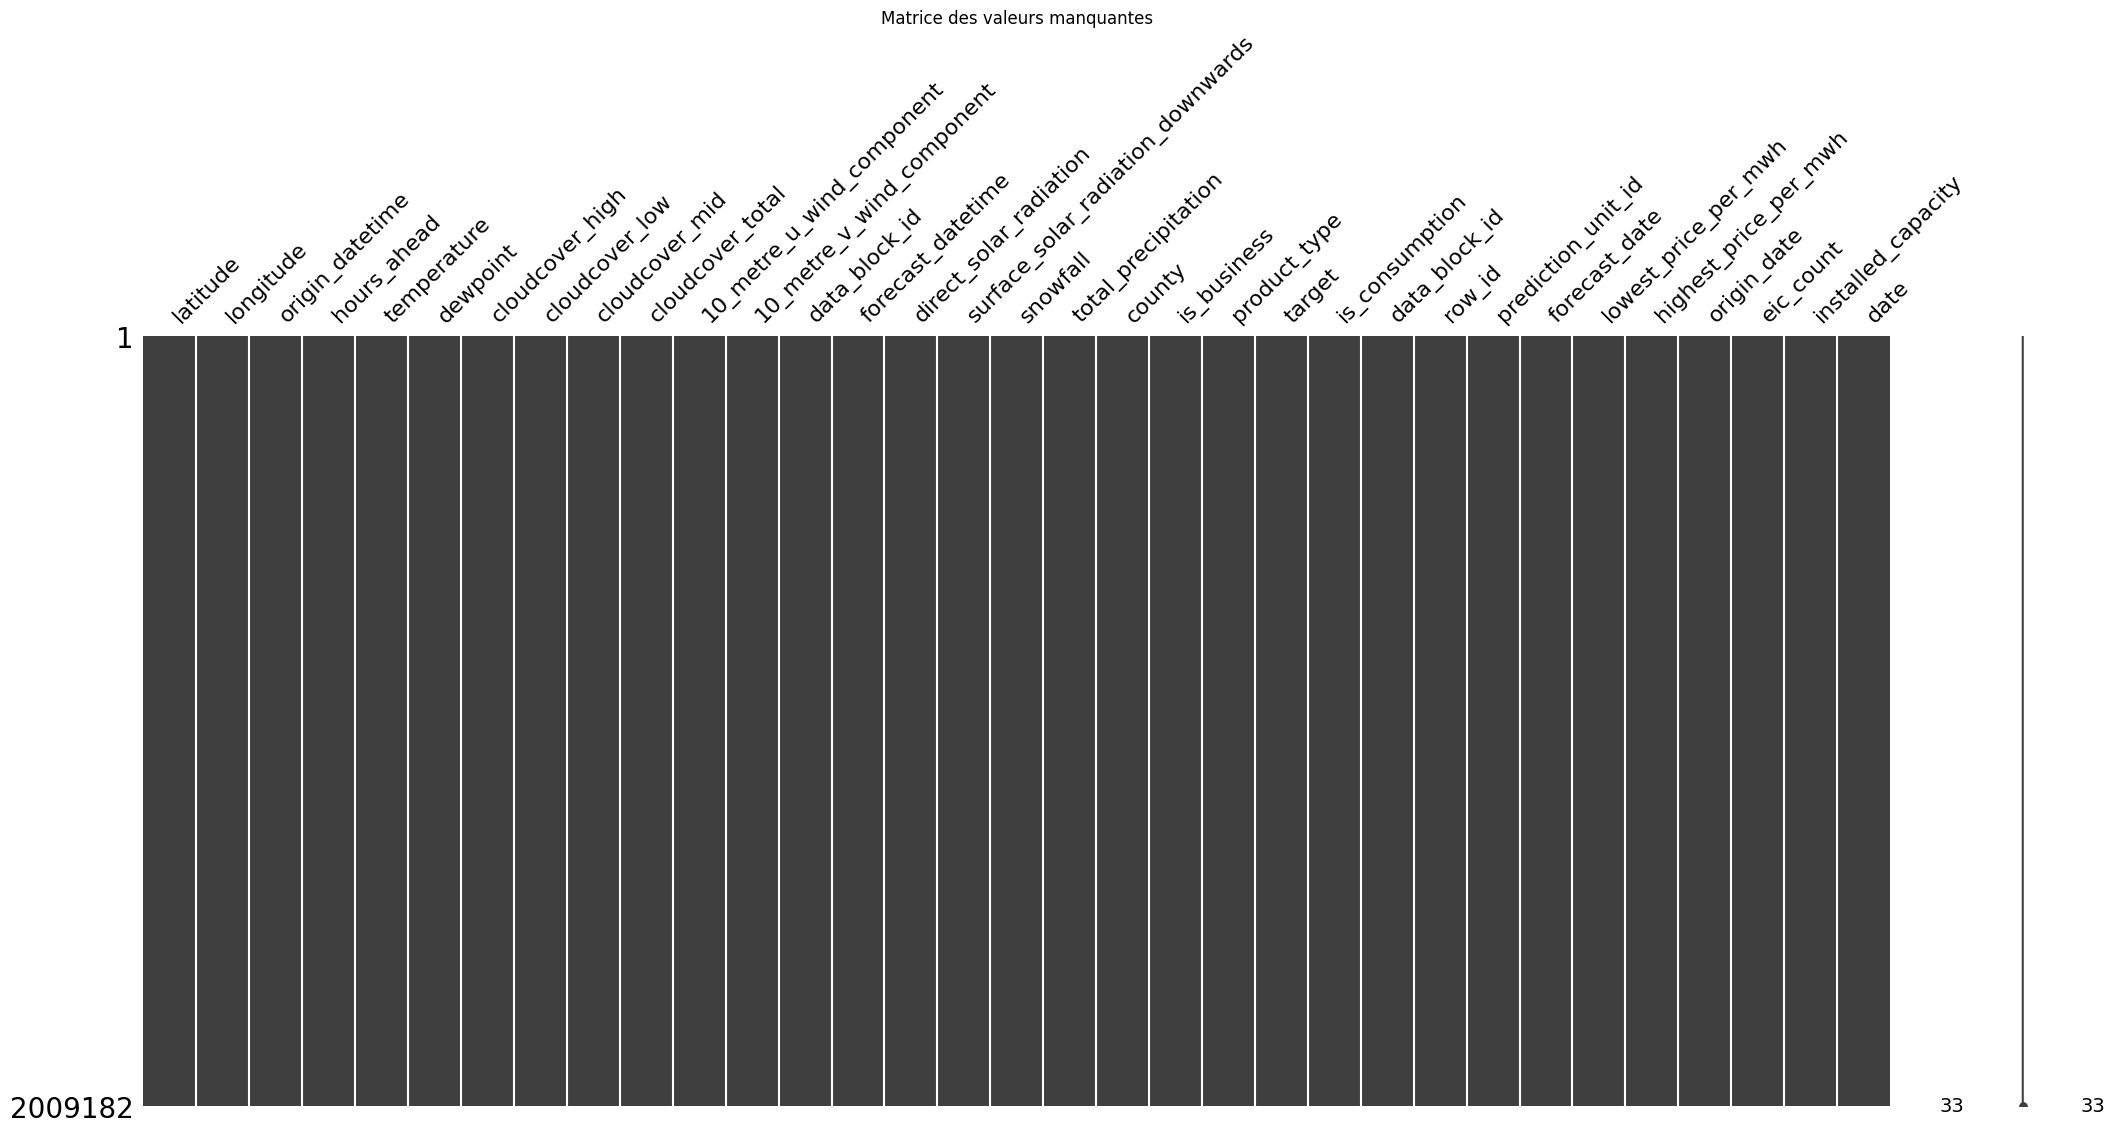

In [28]:
# Missing values
# Matrice des valeurs manquantes
plt.figure(figsize=(12, 6))
msno.matrix(df_train_forecast)
plt.title('Matrice des valeurs manquantes')
plt.show()


# EDA

### data Visualisation 

- Analyse univarié 
- feature engeneering
- Analyse de colinéarité

In [31]:
df_train_forecast.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2009182 entries, 2021-09-03 00:00:00 to 2023-05-31 23:00:00
Data columns (total 33 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   latitude                           float64       
 1   longitude                          float64       
 2   origin_datetime                    datetime64[ns]
 3   hours_ahead                        int64         
 4   temperature                        float64       
 5   dewpoint                           float64       
 6   cloudcover_high                    float64       
 7   cloudcover_low                     float64       
 8   cloudcover_mid                     float64       
 9   cloudcover_total                   float64       
 10  10_metre_u_wind_component          float64       
 11  10_metre_v_wind_component          float64       
 12  data_block_id                      int64         
 13  forecast_datetime       

### Monthly production energy

Pour January 2022 la production moyenne est de 2.82430481582877
Pour January 2023 la production moyenne est de 4.858128247015166
Pour February 2022 la production moyenne est de 15.845479155411489
Pour February 2023 la production moyenne est de 17.742432730116178
Pour March 2022 la production moyenne est de 91.52969816075603
Pour March 2023 la production moyenne est de 71.51958456646692
Pour April 2022 la production moyenne est de 130.5580373873874
Pour April 2023 la production moyenne est de 220.91586209857462


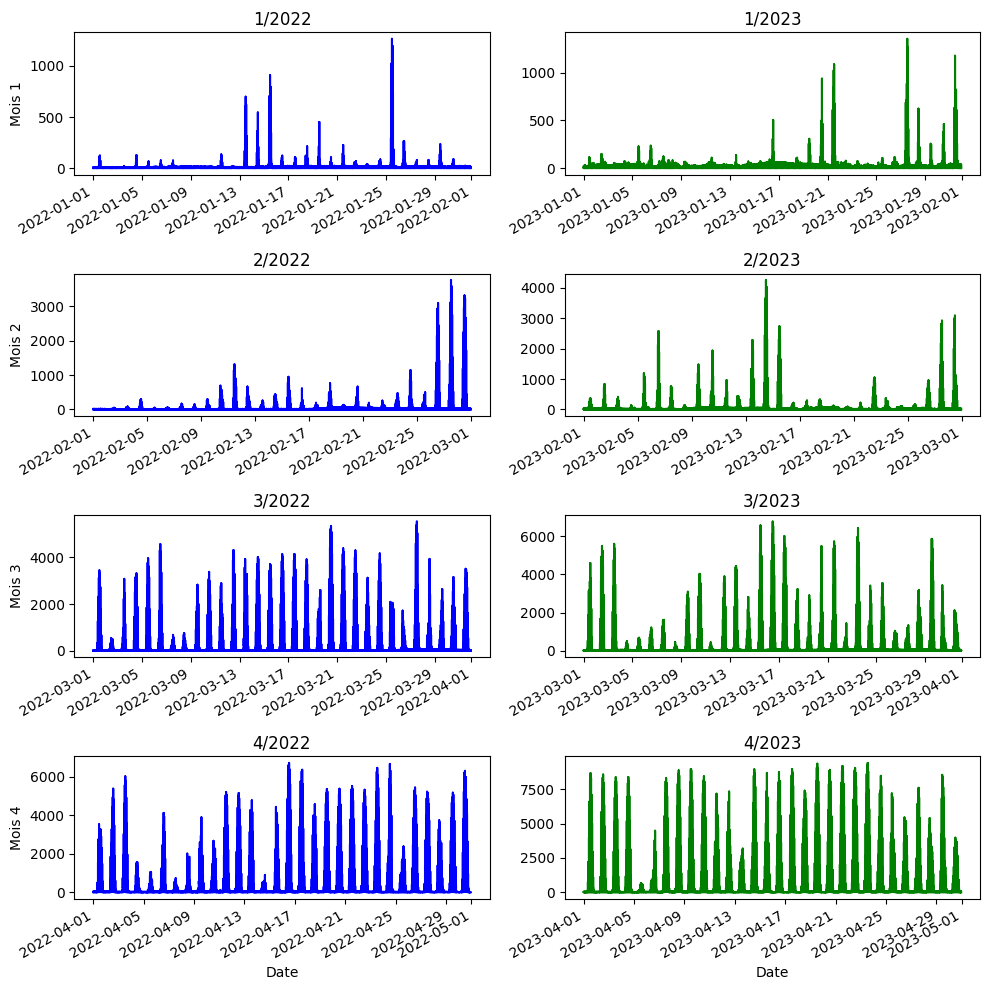

In [32]:
# Filtre les données pour les mois de septembre à décembre pour les années 2021, 2022 et 2023
months = np.arange(1,5)
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']
years = [2022, 2023]
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
colors = ['blue', 'green', 'red']

for i, month in enumerate(months):
    for j, year in enumerate(years):
        df = df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.month == month) & (df_train_forecast['origin_datetime'].dt.year == year) & (df_train_forecast['is_consumption'] == 0),'target']
                
        print(f"Pour {Months[month-1]} {year} la production moyenne est de",df.mean())

        ax = axs[i, j]
        if not df.empty:
            df.plot(ax=ax, y='target', x='date', title=f'{month}/{year}', color=colors[j])
            #ax.fill_between(df['datetime'], df['target'], color=colors[j], alpha=0.1)
        ax.set_xlabel('')
        ax.set_ylabel('')
        if j == 0:
            ax.set_ylabel(f'Mois {month}')
        if i == len(months) - 1:
            ax.set_xlabel('Date')
# Ajuster les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()


### Observations sur la Production d'Énergie Électrique via les Panneaux Solaires

#### Janvier 2022 et 2023
- **Production Moyenne**:
  - 2022: 2 Watts
  - 2023: 4 Watts
- **Observations**:
  - La production est très faible en janvier, ce qui est cohérent avec la faible intensité solaire hivernale.
  - Des pics de production dépassant les 500 watts apparaissent au milieu et à la fin du mois, suggérant une demande accrue pendant ces périodes.

#### Février 2022 et 2023
- **Production Moyenne**:
  - 2022: 15 Watts
  - 2023: 17 Watts
- **Observations**:
  - Une légère augmentation de la production par rapport à janvier, probablement due à l'allongement des jours et à une meilleure irradiation solaire.
  - Des pics de production dépassant les 1000 watts, souvent observés à mi-février et à la fin du mois, indiquent une utilisation accrue pendant ces périodes spécifiques.

#### Mars 2022 et 2023
- **Production Moyenne**:
  - 2022: 71 Watts
  - 2023: 71 Watts
- **Observations**:
  - Une augmentation significative de la production, probablement liée à l'amélioration des conditions météorologiques et à une meilleure exposition au soleil.
  - Des pics de production dépassant les 1000 watts, répartis tout au long du mois, montrent une demande régulière et accrue.

#### Avril 2022 et 2023
- **Production Moyenne**:
  - 2022: 130 Watts
  - 2023: 220 Watts
- **Observations**:
  - La production continue d'augmenter de manière significative, indiquant une bonne performance des panneaux solaires pendant cette période.
  - Des pics de production dépassant les 6000 watts, suggérant une utilisation intensive de l'énergie solaire, répartie tout au long du mois.

### Conclusion
- **Tendance Générale**: La production d'énergie solaire augmente de manière constante de janvier à avril, ce qui est cohérent avec l'amélioration des conditions météorologiques et l'augmentation de la durée d'ensoleillement.
- **Piques de Consommation**: Les pics de consommation, bien que élevés, semblent se produire régulièrement, ce qui pourrait indiquer une demande accrue pour certaines activités ou une utilisation spécifique de l'énergie pendant ces périodes.
- **Différence Année sur Année**: Une légère augmentation de la production entre 2022 et 2023 pourrait indiquer des améliorations dans l'efficacité des panneaux solaires ou des conditions météorologiques plus favorables en 2023.


Pour May 2022 la production moyenne est de 150.24820165302518
(49848,)
Pour May 2023 la production moyenne est de 346.87271692004504
(49728,)
Pour June 2022 la production moyenne est de 187.33999348439576
(48192,)
Pour June 2023 la production moyenne est de nan
(0,)
Pour July 2022 la production moyenne est de 177.42185553111761
(49104,)
Pour July 2023 la production moyenne est de nan
(0,)
Pour August 2022 la production moyenne est de 161.57480772677283
(49102,)
Pour August 2023 la production moyenne est de nan
(0,)


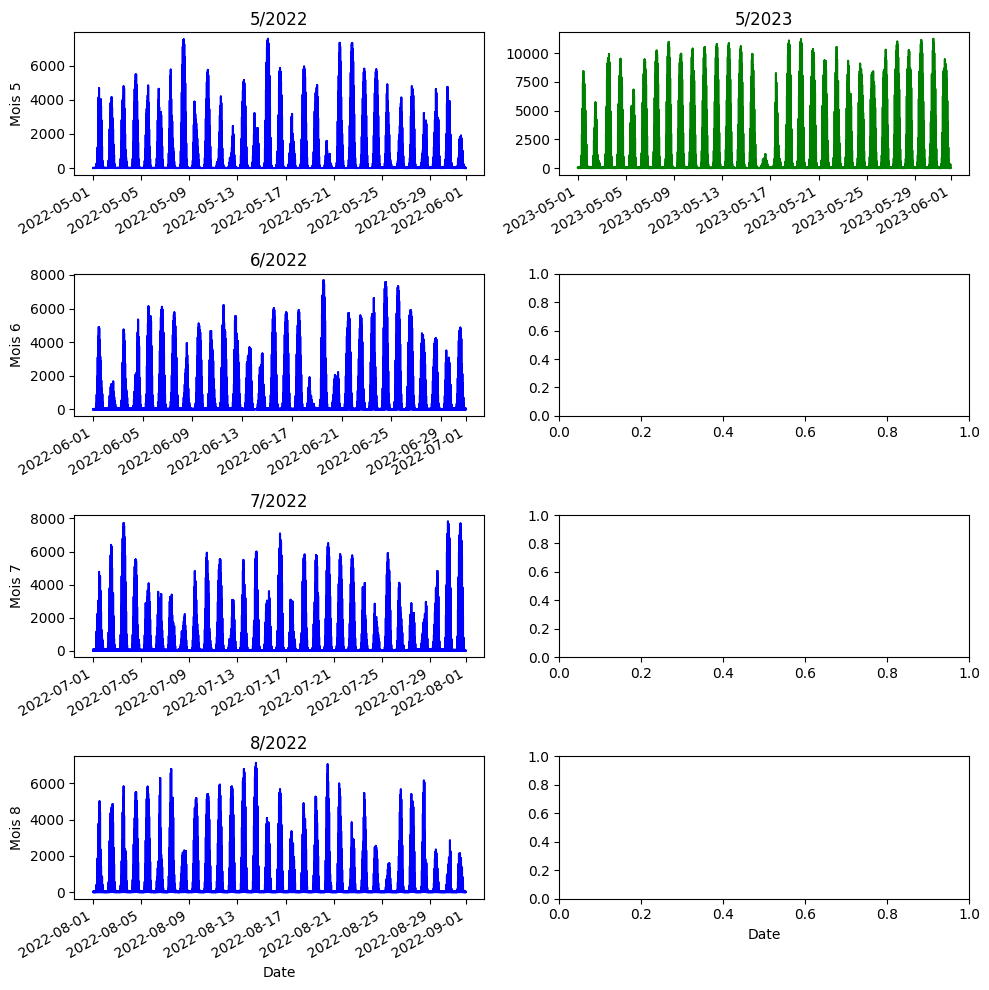

In [22]:
# For the period from September to December in 2022 and 2023, we observe similar seasonal patterns. 

months = np.arange(5,9)
years = [2022, 2023]
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
colors = ['blue', 'green', 'red']
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']

for i, month in enumerate(months):
    for j, year in enumerate(years):
        df = df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.month == month) & (df_train_forecast['origin_datetime'].dt.year == year) & (df_train_forecast['is_consumption'] == 0),'target']
        print(f"Pour {Months[month-1]} {year} la production moyenne est de",df.mean())
        print(df.shape)
        ax = axs[i, j]
        if not df.empty:
            df.plot(ax=ax, y='target', x='date', title=f'{month}/{year}', color=colors[j])
            #ax.fill_between(df['datetime'], df['target'], color=colors[j], alpha=0.1)
        ax.set_xlabel('')
        ax.set_ylabel('')
        if j == 0:
            ax.set_ylabel(f'Mois {month}')
        if i == len(months) - 1:
            ax.set_xlabel('Date')
# Ajuster les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()


### Observations sur la Production Énergétique Mensuelle

#### Mai 2022 et 2023
- **production Moyenne**:
  - 2022: 150.25 kWh
  - 2023: 346.87 kWh
- **Observations**:
  - Une augmentation significative de la production moyenne en mai 2023 par rapport à mai 2022.
  - En 2022, des pics de production réguliers tout au long du mois.
  - En 2023, des pics de production plus fréquents et plus élevés, indiquant une demande accrue d'énergie.

#### Juin 2022 et 2023
- **production Moyenne**:
  - 2022: 187.34 kWh
  - 2023: Données non disponibles
- **Observations**:
  - La production moyenne en juin 2022 est relativement élevée avec des pics réguliers.
  - Les données de production pour juin 2023 ne sont pas disponibles.

#### Juillet 2022 et 2023
- **Production Moyenne**:
  - 2022: 177.42 kWh
  - 2023: Données non disponibles
- **Observations**:
  - La consommation moyenne en juillet 2022 est relativement élevée avec des pics réguliers.
  - Les données de consommation pour juillet 2023 ne sont pas disponibles.

#### Août 2022 et 2023
- **Consommation Moyenne**:
  - 2022: 161.57 kWh
  - 2023: Données non disponibles
- **Observations**:
  - La consommation moyenne en août 2022 est relativement élevée avec des pics réguliers.
  - Les données de consommation pour août 2023 ne sont pas disponibles.

### Conclusion
- **Tendance Générale**: La production énergétique montre une augmentation significative en mai 2023 par rapport à mai 2022, tandis que les données pour les mois de juin, juillet et août 2023 ne sont pas disponibles.
- **Piques de Consommation**: Les pics de production sont plus élevés et plus fréquents en mai 2023, suggérant une demande énergétique accrue.
- **Analyse Mensuelle**: Chaque mois présente des caractéristiques uniques de production, avec une augmentation notable en mai 2023.

Pour September 2021 la production moyenne est de 63.30377500487901
(40992,)
Pour September 2022 la production moyenne est de 110.06309045069722
(48192,)
Pour October 2021 la production moyenne est de 35.988723561555766
(46665,)
Pour October 2022 la production moyenne est de 41.23968353276805
(50476,)
Pour November 2021 la production moyenne est de 7.9936659391534395
(45360,)
Pour November 2022 la production moyenne est de 6.533777341231463
(49632,)
Pour December 2021 la production moyenne est de 1.43754572441483
(46824,)
Pour December 2022 la production moyenne est de 2.2372290160642567
(49800,)


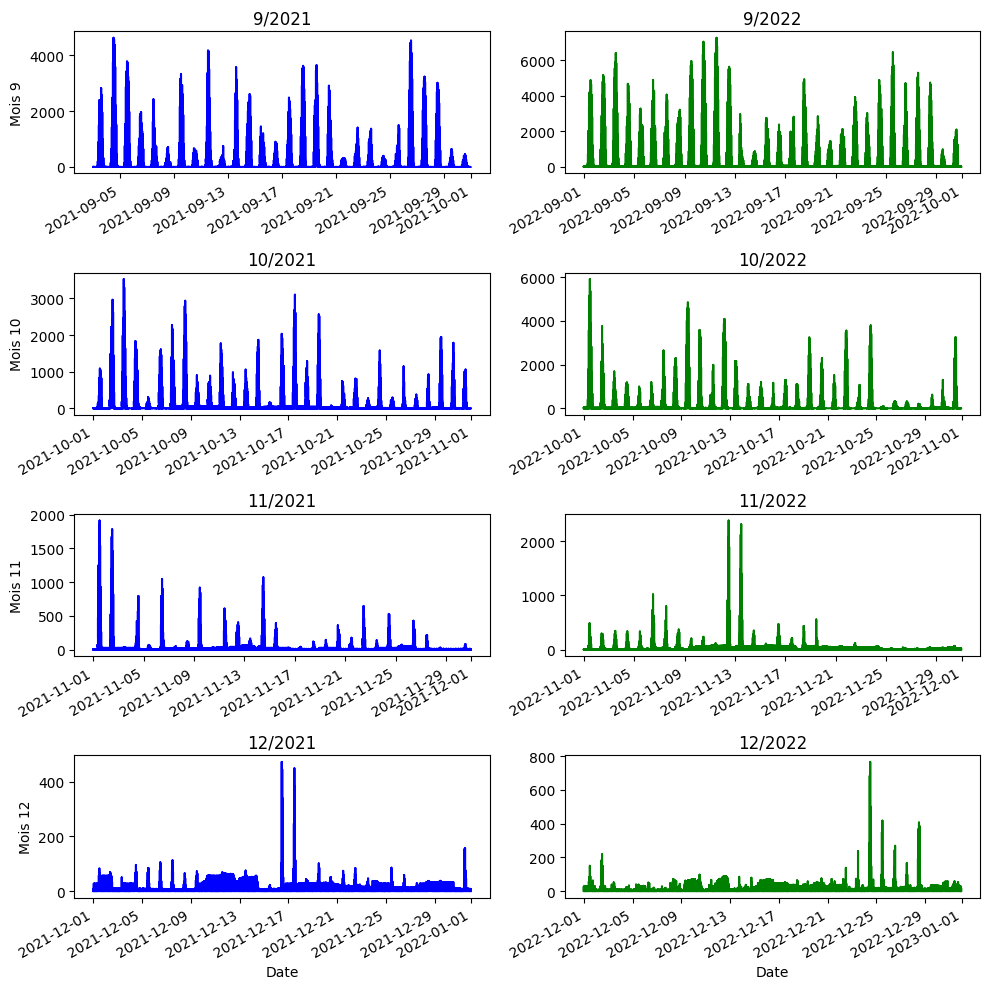

In [23]:
# For the period from September to December in 2021 and 2022, we observe similar seasonal patterns. 
# Filtre les données pour les mois de septembre à décembre pour les années 2021, 2022 et 2023
months = np.arange(9,13)
years = [2021, 2022]
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
colors = ['blue', 'green', 'red']
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']

for i, month in enumerate(months):
    for j, year in enumerate(years):
        df = df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.month == month) & (df_train_forecast['origin_datetime'].dt.year == year) & (df_train_forecast['is_consumption'] == 0),'target']
        print(f"Pour {Months[month-1]} {year} la production moyenne est de",df.mean())
        print(df.shape)
        ax = axs[i, j]
        if not df.empty:
            df.plot(ax=ax, y='target', x='date', title=f'{month}/{year}', color=colors[j])
            #ax.fill_between(df['datetime'], df['target'], color=colors[j], alpha=0.1)
        ax.set_xlabel('')
        ax.set_ylabel('')
        if j == 0:
            ax.set_ylabel(f'Mois {month}')
        if i == len(months) - 1:
            ax.set_xlabel('Date')
# Ajuster les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()


### Observations sur la Production Énergétique Mensuelle

#### Septembre 2021 et 2022
- **Production Moyenne**:
  - 2021: 63.30 kWh
  - 2022: 110.06 kWh
- **Observations**:
  - Une augmentation notable de la production moyenne en septembre 2022 par rapport à septembre 2021.
  - En 2021, des pics de production réguliers tout au long du mois.
  - En 2022, des pics de production plus fréquents et plus élevés, indiquant une demande accrue d'énergie.

#### Octobre 2021 et 2022
- **Production Moyenne**:
  - 2021: 35.99 kWh
  - 2022: 41.24 kWh
- **Observations**:
  - Une légère augmentation de la production moyenne en octobre 2022 par rapport à octobre 2021.
  - En 2021, des pics de production variés tout au long du mois.
  - En 2022, des pics de production plus fréquents, mais d'intensité similaire à ceux de 2021.

#### Novembre 2021 et 2022
- **Production Moyenne**:
  - 2021: 7.99 kWh
  - 2022: 6.53 kWh
- **Observations**:
  - Une légère diminution de la production moyenne en novembre 2022 par rapport à novembre 2021.
  - En 2021, des pics de production sont présents mais moins fréquents.
  - En 2022, une tendance similaire avec des pics moins élevés, indiquant une baisse globale de la production énergétique.

#### Décembre 2021 et 2022
- **Production Moyenne**:
  - 2021: 1.44 kWh
  - 2022: 2.24 kWh
- **Observations**:
  - Une augmentation de la production moyenne en décembre 2022 par rapport à décembre 2021.
  - En 2021, des pics de production faibles et sporadiques tout au long du mois.
  - En 2022, des pics légèrement plus élevés mais toujours sporadiques, indiquant une légère hausse de la demande énergétique.

### Conclusion
- **Tendance Générale**: La production énergétique montre des variations significatives entre les différentes années et les mois, avec des augmentations notables en septembre et décembre.
- **Piques de Consommation**: Les pics de consommation sont plus fréquents et plus élevés en 2022 par rapport à 2021, suggérant une demande énergétique accrue.
- **Analyse Mensuelle**: Chaque mois présente des caractéristiques uniques de production, avec une augmentation globale de la production en septembre et décembre, et une légère baisse en novembre.


### Monthly consumption energy

Pour January 2022 la consommation moyenne est de 521.5431451178032
Pour January 2023 la consommation moyenne est de 645.1559315303323
Pour February 2022 la consommation moyenne est de 516.295188074014
Pour February 2023 la consommation moyenne est de 651.9238598525469
Pour March 2022 la consommation moyenne est de 441.707797337669
Pour March 2023 la consommation moyenne est de 593.0753170070524
Pour April 2022 la consommation moyenne est de 384.7432782350532
Pour April 2023 la consommation moyenne est de 442.0482401682981


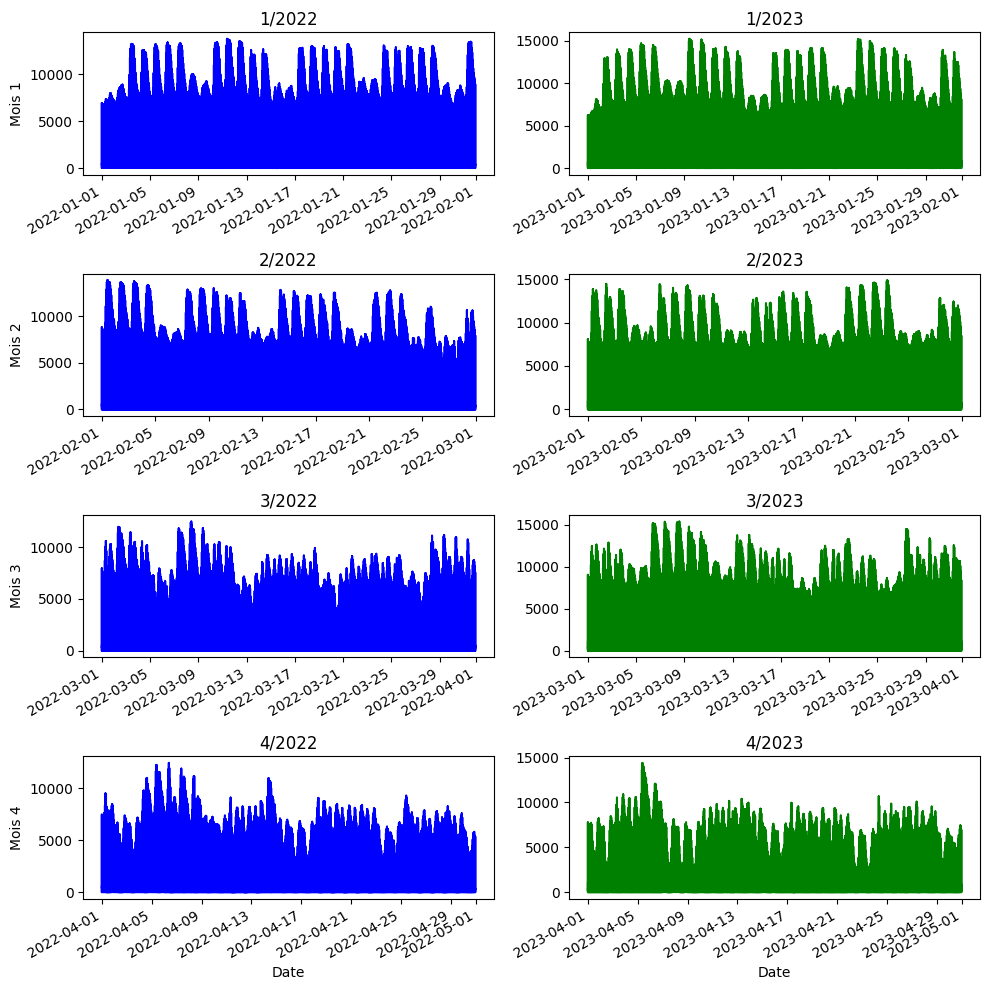

In [24]:
# Filtre les données pour les mois de septembre à décembre pour les années 2021, 2022 et 2023
months = np.arange(1,5)
years = [2022, 2023]
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
colors = ['blue', 'green', 'red']
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']

for i, month in enumerate(months):
    for j, year in enumerate(years):
        df = df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.month == month) & (df_train_forecast['origin_datetime'].dt.year == year) & (df_train_forecast['is_consumption'] == 1),'target']
        print(f"Pour {Months[month-1]} {year} la consommation moyenne est de",df.mean())
        ax = axs[i, j]
        if not df.empty:
            df.plot(ax=ax, y='target', x='date', title=f'{month}/{year}', color=colors[j])
            #ax.fill_between(df['datetime'], df['target'], color=colors[j], alpha=0.1)
        ax.set_xlabel('')
        ax.set_ylabel('')
        if j == 0:
            ax.set_ylabel(f'Mois {month}')
        if i == len(months) - 1:
            ax.set_xlabel('Date')
# Ajuster les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()

### Observations sur la Consommation Énergétique Mensuelle

#### Janvier 2022 et 2023
- **Consommation Moyenne**:
  - 2022: 521.54 kWh
  - 2023: 645.16 kWh
- **Observations**:
  - Une augmentation notable de la consommation moyenne en janvier 2023 par rapport à janvier 2022.
  - Des pics de consommation réguliers et relativement élevés tout au long du mois pour les deux années.
  - La consommation semble plus constante et légèrement plus élevée en 2023.

#### Février 2022 et 2023
- **Consommation Moyenne**:
  - 2022: 516.30 kWh
  - 2023: 651.92 kWh
- **Observations**:
  - Une augmentation significative de la consommation moyenne en février 2023 par rapport à février 2022.
  - Des pics de consommation similaires en fréquence mais plus élevés en 2023.
  - La consommation reste élevée et constante tout au long du mois en 2023.

#### Mars 2022 et 2023
- **Consommation Moyenne**:
  - 2022: 441.71 kWh
  - 2023: 593.08 kWh
- **Observations**:
  - Une augmentation de la consommation moyenne en mars 2023 par rapport à mars 2022.
  - Des pics de consommation plus élevés et fréquents en 2023.
  - Une consommation plus variable en 2022 comparée à une consommation plus stable en 2023.

#### Avril 2022 et 2023
- **Consommation Moyenne**:
  - 2022: 384.74 kWh
  - 2023: 442.05 kWh
- **Observations**:
  - Une augmentation de la consommation moyenne en avril 2023 par rapport à avril 2022.
  - Des pics de consommation réguliers mais légèrement plus élevés en 2023.
  - Une tendance à une consommation plus élevée en 2023 tout au long du mois.

### Conclusion
- **Tendance Générale**: La consommation énergétique montre une augmentation significative de 2022 à 2023 pour les mois de janvier à avril.
- **Piques de Consommation**: Les pics de consommation sont plus élevés et plus fréquents en 2023, suggérant une demande énergétique accrue.
- **Analyse Mensuelle**: Chaque mois présente une augmentation de la consommation en 2023 par rapport à 2022, avec une tendance à une consommation plus stable et plus élevée en 2023.


Pour September 2021 la consommation moyenne est de 367.6111481996487
(40992,)
Pour September 2022 la consommation moyenne est de 400.6753124169987
(48192,)
Pour October 2021 la consommation moyenne est de 400.73723010821817
(46665,)
Pour October 2022 la consommation moyenne est de 462.3017852444726
(50476,)
Pour November 2021 la consommation moyenne est de 462.99353979276896
(45360,)
Pour November 2022 la consommation moyenne est de 548.4960630641522
(49632,)
Pour December 2021 la consommation moyenne est de 507.13006069536993
(46824,)
Pour December 2022 la consommation moyenne est de 605.0669500803212
(49800,)


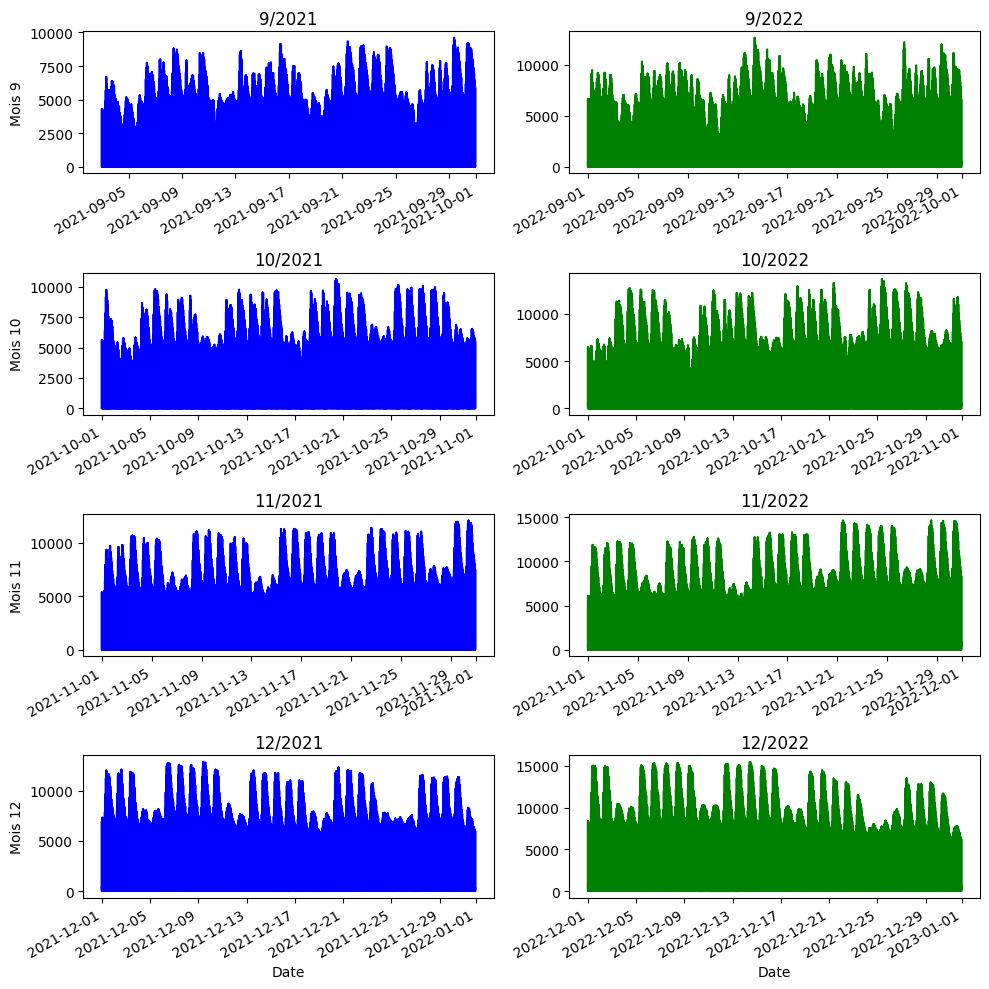

In [25]:
# For the period from September to December in 2021 and 2022, we observe similar seasonal patterns. 
# Filtre les données pour les mois de septembre à décembre pour les années 2021, 2022 et 2023
months = np.arange(9,13)
years = [2021, 2022]
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
colors = ['blue', 'green', 'red']
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']

for i, month in enumerate(months):
    for j, year in enumerate(years):
        df = df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.month == month) & (df_train_forecast['origin_datetime'].dt.year == year) & (df_train_forecast['is_consumption'] == 1),'target']
        print(f"Pour {Months[month-1]} {year} la consommation moyenne est de",df.mean())
        print(df.shape)
        ax = axs[i, j]
        if not df.empty:
            df.plot(ax=ax, y='target', x='date', title=f'{month}/{year}', color=colors[j])
            #ax.fill_between(df['datetime'], df['target'], color=colors[j], alpha=0.1)
        ax.set_xlabel('')
        ax.set_ylabel('')
        if j == 0:
            ax.set_ylabel(f'Mois {month}')
        if i == len(months) - 1:
            ax.set_xlabel('Date')
# Ajuster les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()

### Observations sur la Consommation Énergétique Mensuelle

#### Septembre 2021 et 2022
- **Consommation Moyenne**:
  - 2021: 367.61 kWh
  - 2022: 400.68 kWh
- **Observations**:
  - Une augmentation de la consommation moyenne en septembre 2022 par rapport à septembre 2021.
  - En 2021, des pics de consommation réguliers tout au long du mois.
  - En 2022, des pics de consommation plus élevés, indiquant une demande accrue d'énergie.

#### Octobre 2021 et 2022
- **Consommation Moyenne**:
  - 2021: 400.74 kWh
  - 2022: 462.30 kWh
- **Observations**:
  - Une augmentation significative de la consommation moyenne en octobre 2022 par rapport à octobre 2021.
  - Des pics de consommation réguliers tout au long du mois pour les deux années, mais plus élevés en 2022.

#### Novembre 2021 et 2022
- **Consommation Moyenne**:
  - 2021: 462.99 kWh
  - 2022: 548.50 kWh
- **Observations**:
  - Une augmentation notable de la consommation moyenne en novembre 2022 par rapport à novembre 2021.
  - Des pics de consommation réguliers tout au long du mois pour les deux années, mais plus élevés en 2022.

#### Décembre 2021 et 2022
- **Consommation Moyenne**:
  - 2021: 507.13 kWh
  - 2022: 605.07 kWh
- **Observations**:
  - Une augmentation significative de la consommation moyenne en décembre 2022 par rapport à décembre 2021.
  - Des pics de consommation réguliers tout au long du mois pour les deux années, mais plus élevés en 2022.

### Conclusion
- **Tendance Générale**: La consommation énergétique montre une augmentation significative de 2021 à 2022 pour les mois de septembre à décembre.
- **Piques de Consommation**: Les pics de consommation sont plus élevés en 2022, suggérant une demande énergétique accrue.
- **Analyse Mensuelle**: Chaque mois présente une augmentation de la consommation en 2022 par rapport à 2021, avec une tendance à une consommation plus stable et plus élevée en 2022.


## Monthly consumption and production energy 

Pour May 2022 la production-consommation moyenne est de 252.59033179866796
Pour May 2023 la production-consommation moyenne est de 363.78647482303734
Pour June 2022 la production-consommation moyenne est de 247.05935683308428
Pour June 2023 la production-consommation moyenne est de nan
Pour July 2022 la production-consommation moyenne est de 247.0795112007169
Pour July 2023 la production-consommation moyenne est de nan
Pour August 2022 la production-consommation moyenne est de 271.2485408834491
Pour August 2023 la production-consommation moyenne est de nan


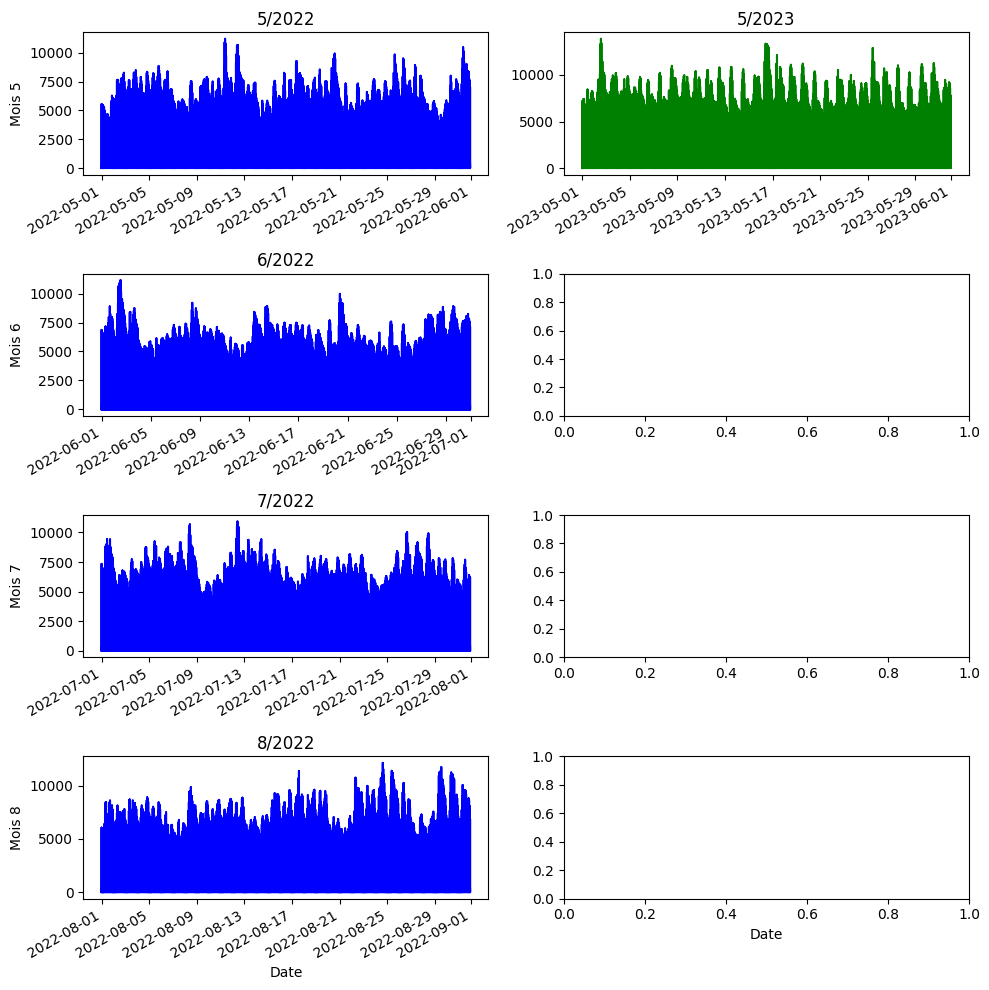

In [26]:
# Filtre les données pour les mois de septembre à décembre pour les années 2021, 2022 et 2023
months = np.arange(5,9)
years = [2022, 2023]
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
colors = ['blue', 'green', 'red']
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']

for i, month in enumerate(months):
    for j, year in enumerate(years):
        df = df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.month == month) & (df_train_forecast['origin_datetime'].dt.year == year),'target']
        print(f"Pour {Months[month-1]} {year} la production-consommation moyenne est de",df.mean())
        ax = axs[i, j]
        if not df.empty:
            df.plot(ax=ax, y='target', x='date', title=f'{month}/{year}', color=colors[j])
            #ax.fill_between(df['datetime'], df['target'], color=colors[j], alpha=0.1)
        ax.set_xlabel('')
        ax.set_ylabel('')
        if j == 0:
            ax.set_ylabel(f'Mois {month}')
        if i == len(months) - 1:
            ax.set_xlabel('Date')
# Ajuster les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()


Pour September 2021 la production-consommation moyenne est de 215.45746160226386
Pour September 2022 la production-consommation moyenne est de 255.3692014338479
Pour October 2021 la production-consommation moyenne est de 218.36297683488698
Pour October 2022 la production-consommation moyenne est de 251.77073438862033
Pour November 2021 la production-consommation moyenne est de 235.49360286596118
Pour November 2022 la production-consommation moyenne est de 277.51492020269177
Pour December 2021 la production-consommation moyenne est de 254.2838032098923
Pour December 2022 la production-consommation moyenne est de 303.65208954819275


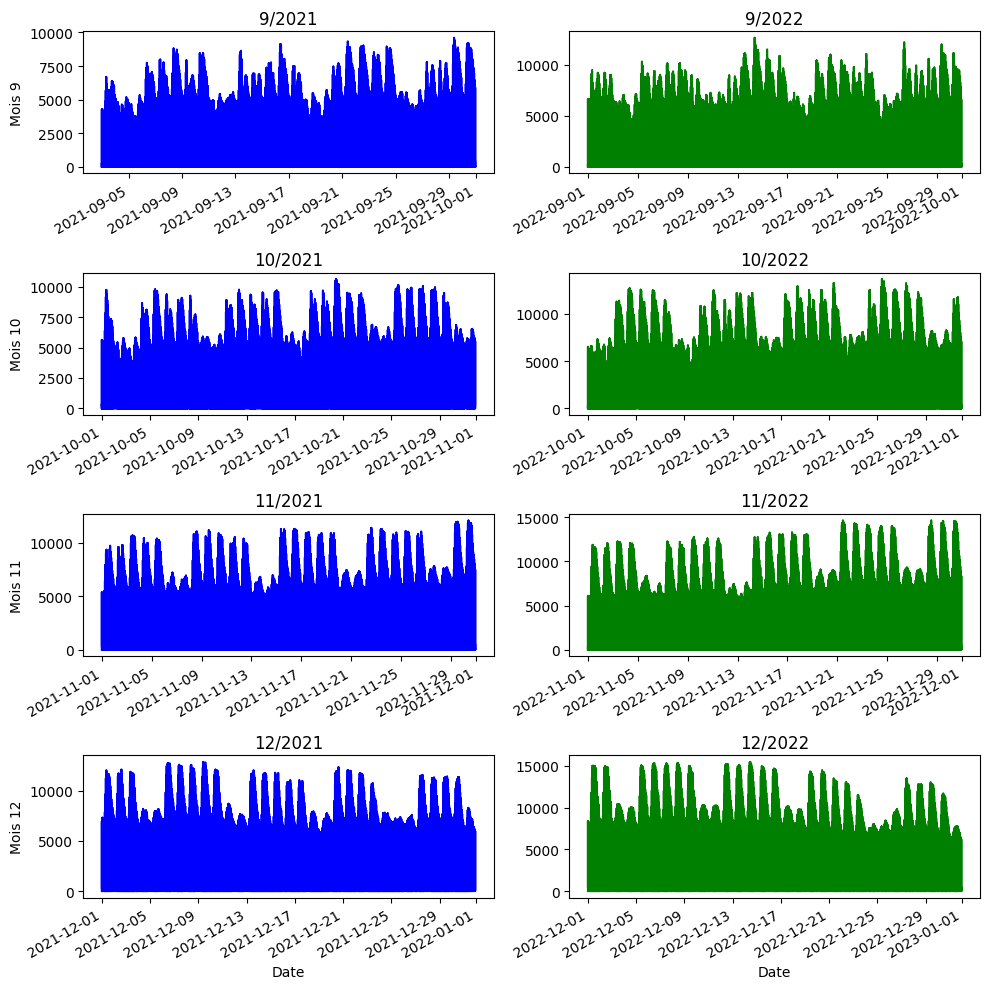

In [27]:
months = np.arange(9,13)
years = [2021, 2022]
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
colors = ['blue', 'green', 'red']
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']

for i, month in enumerate(months):
    for j, year in enumerate(years):
        df = df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.month == month) & (df_train_forecast['origin_datetime'].dt.year == year),'target']
        print(f"Pour {Months[month-1]} {year} la production-consommation moyenne est de",df.mean())

        ax = axs[i, j]
        if not df.empty:
            df.plot(ax=ax, y='target', x='date', title=f'{month}/{year}', color=colors[j])
        ax.set_xlabel('')
        ax.set_ylabel('')
        if j == 0:
            ax.set_ylabel(f'Mois {month}')
        if i == len(months) - 1:
            ax.set_xlabel('Date')
# Ajuster les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()


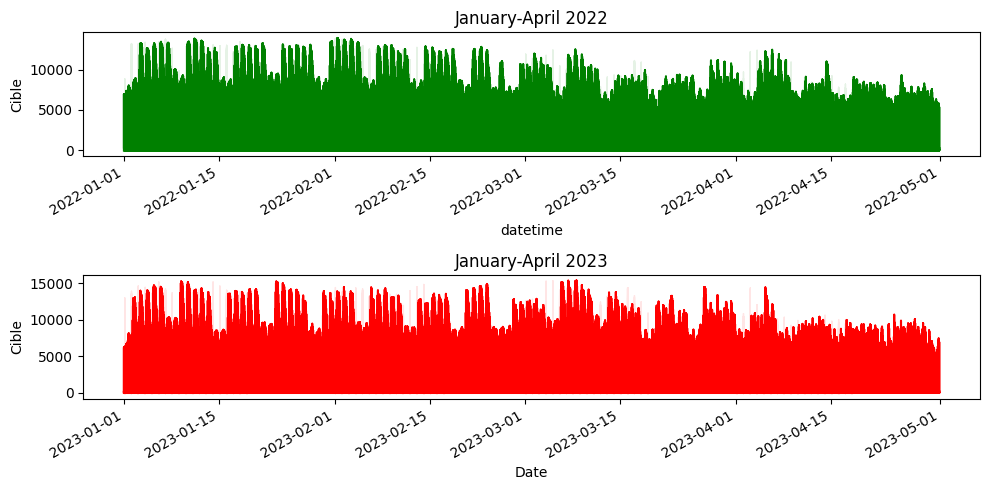

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_train_forecast is your DataFrame
df_train_forecast['datetime'] = pd.to_datetime(df_train_forecast['origin_datetime'])
            #ax.fill_between(df['datetime'], df['target'], color=colors[j], alpha=0.1)

# Filtre les données pour les années  2022 et 2023
df_january_april_2022 = df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.month >=1)&(df_train_forecast['origin_datetime'].dt.month <= 4)& (df_train_forecast['origin_datetime'].dt.year == 2022)]
df_january_april__2023 = df_train_forecast.loc[(df_train_forecast['datetime'].dt.month >=1)&(df_train_forecast['datetime'].dt.month <= 4)& (df_train_forecast['datetime'].dt.year == 2023)]

fig, axs = plt.subplots(2, 1, figsize=(10, 5))

# Tracer les données pour chaque année sur des sous-graphiques séparés avec des bandes de couleur

df_january_april_2022.target.plot(ax=axs[0], x='datetime', title='January-April 2022', color='green')
axs[0].fill_between(df_january_april_2022['datetime'], df_january_april_2022['target'], color='green', alpha=0.1)

df_january_april__2023.target.plot(ax=axs[1],  x='datetime', title='January-April 2023', color='red')
axs[1].fill_between(df_january_april__2023['datetime'], df_january_april__2023['target'], color='red', alpha=0.1)

# Ajouter des labels
axs[1].set_xlabel('Date')
for ax in axs:
    ax.set_ylabel('Cible')

plt.tight_layout()

plt.show()



In [40]:
print(f'max comsumption january to april {df_january_april_2022.target.max()}, mean consumption january to april {df_january_april_2022.target.mean()}, low consumption january to april {df_january_april_2022.target.min()}' )

max comsumption january to april 13896.422, mean consumption january to april 263.0725678160317, low consumption january to april 0.0


- We can see the seasonality every three months. The consumption varies from 0 to 13,896.

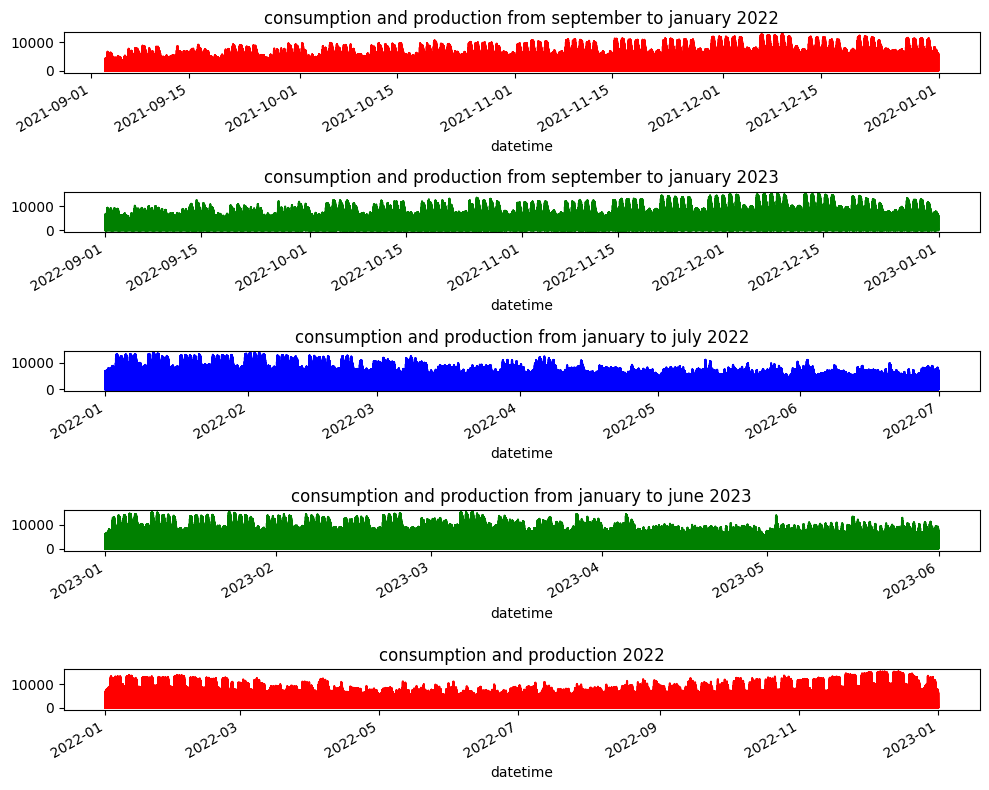

In [41]:
fig, ax = plt.subplots(5,1,figsize=(10,8))
df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.year == 2021),'target'].plot(ax=ax[0],color='red',title = 'consumption and production from september to january 2022')
df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.year == 2022)&(df_train_forecast['origin_datetime'].dt.month >= 9)&(df_train_forecast['origin_datetime'].dt.month <= 12),'target'].plot(ax=ax[1],color='green', title = 'consumption and production from september to january 2023')
df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.year == 2022)&(df_train_forecast['origin_datetime'].dt.month >= 1)&(df_train_forecast['origin_datetime'].dt.month <= 6),'target'].plot(ax=ax[2],color='blue', title = 'consumption and production from january to july 2022')
df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.year == 2023),'target'].plot(ax=ax[3],color='green', title = 'consumption and production from january to june 2023')
df_train_forecast.loc[(df_train_forecast['origin_datetime'].dt.year == 2022),'target'].plot(ax=ax[4], color='red',title = 'consumption and production 2022')

plt.tight_layout()
plt.show()

# 2.2 univariate analysis

In [33]:
df_train_forecast.head(7)

latitude  longitude     origin_datetime  hours_ahead  temperature  \
datetime                                                                        
2021-09-03      58.2       23.7 2021-09-02 02:00:00            5    13.476221   
2021-09-03      58.2       24.2 2021-09-02 02:00:00            5    11.961450   
2021-09-03      58.2       24.7 2021-09-02 02:00:00            5    10.000146   
2021-09-03      58.2       25.2 2021-09-02 02:00:00            5     8.649683   
2021-09-03      58.2       25.7 2021-09-02 02:00:00            5     8.485620   
2021-09-03      58.2       26.2 2021-09-02 02:00:00            5     9.599756   
2021-09-03      58.2       26.7 2021-09-02 02:00:00            5     8.753809   

            dewpoint  cloudcover_high  cloudcover_low  cloudcover_mid  \
datetime                                                                
2021-09-03  6.160547              0.0        0.238205        0.304855   
2021-09-03  7.848840              0.0        0.025429        0.007751   
2021-09-03  6.802637              0.0        0.000954        0.000412   
2021-09-03  6.022607              0.0        0.002556        0.000214   
2021-09-03  5.985437              0.0        0.008598        0.000153   
2021-09-03  6.760217              0.0        0.022346        0.000839   
2021-09-03  6.130945              0.0        0.062500        0.006287   

            cloudcover_total  ...  data_block_id  row_id  prediction_unit_id  \
datetime                      ...                                              
2021-09-03          0.367310  ...            2.0  5856.0                 0.0   
2021-09-03          0.029190  ...            2.0  5857.0                 0.0   
2021-09-03          0.001251  ...            2.0  5858.0                 1.0   
2021-09-03          0.002609  ...            2.0  5859.0                 1.0   
2021-09-03          0.008652  ...            2.0  5860.0                 2.0   
2021-09-03          0.022461  ...            2.0  5861.0                 2.0   
2021-09-03          0.063446  ...            2.0  5862.0                 3.0   

           forecast_date  lowest_price_per_mwh  highest_price_per_mwh  \
datetime                                                                
2021-09-03    2021-09-02                 45.62                  46.29   
2021-09-03    2021-09-02                 45.62                  46.29   
2021-09-03    2021-09-02                 45.62                  46.29   
2021-09-03    2021-09-02                 45.62                  46.29   
2021-09-03    2021-09-02                 45.62                  46.29   
2021-09-03    2021-09-02                 45.62                  46.29   
2021-09-03    2021-09-02                 45.62                  46.29   

            origin_date  eic_count  installed_capacity        date  
datetime                                                            
2021-09-03   2021-09-01      108.0              952.89  2021-09-01  
2021-09-03   2021-09-01      108.0              952.89  2021-09-01  
2021-09-03   2021-09-01       17.0              166.40  2021-09-01  
2021-09-03   2021-09-01       17.0              166.40  2021-09-01  
2021-09-03   2021-09-01      688.0             7207.88  2021-09-01  
2021-09-03   2021-09-01      688.0             7207.88  2021-09-01  
2021-09-03   2021-09-01        5.0              400.00  2021-09-01  

[7 rows x 33 columns]

In [34]:

cols = df_train_forecast.drop(columns=[ 'latitude', 'longitude','county','row_id','origin_datetime',
                                        'date','hours_ahead','forecast_datetime',
                                        'forecast_date','origin_date','data_block_id','prediction_unit_id']).columns

df_train_forecast[cols].describe()

temperature      dewpoint  cloudcover_high  cloudcover_low  \
count  2.009182e+06  2.009182e+06     2.009182e+06    2.009182e+06   
mean   5.650304e+00  2.299228e+00     4.069380e-01    4.140792e-01   
std    7.835610e+00  7.153458e+00     4.459857e-01    4.352419e-01   
min   -2.749940e+01 -2.968357e+01     0.000000e+00    0.000000e+00   
25%    3.705078e-01 -2.339011e+00     0.000000e+00    3.051758e-05   
50%    4.853784e+00  1.745508e+00     1.199341e-01    1.891093e-01   
75%    1.132693e+01  7.384302e+00     9.841919e-01    9.974060e-01   
max    3.124551e+01  2.267642e+01     1.000008e+00    1.000008e+00   

       cloudcover_mid  cloudcover_total  10_metre_u_wind_component  \
count    2.009182e+06      2.009182e+06               2.009182e+06   
mean     3.583938e-01      6.834849e-01               1.420230e+00   
std      4.184010e-01      3.987929e-01               3.980333e+00   
min      0.000000e+00      0.000000e+00              -1.640865e+01   
25%      0.000000e+00      2.743681e-01              -1.255973e+00   
50%      1.062164e-01      9.750223e-01               1.580778e+00   
75%      8.916321e-01      9.999999e-01               3.979206e+00   
max      1.000008e+00      1.000008e+00               2.203584e+01   

       10_metre_v_wind_component  direct_solar_radiation  \
count               2.009182e+06            2.009182e+06   
mean                1.051695e+00            1.529315e+02   
std                 4.205041e+00            2.569409e+02   
min                -2.211612e+01           -7.733333e-01   
25%                -1.646978e+00            0.000000e+00   
50%                 1.244626e+00            0.000000e+00   
75%                 3.813584e+00            2.230671e+02   
max                 1.810218e+01            9.544222e+02   

       surface_solar_radiation_downwards      snowfall  total_precipitation  \
count                       2.009182e+06  2.009182e+06         2.009182e+06   
mean                        1.113336e+02  2.511451e-05         7.885371e-05   
std                         1.867650e+02  1.223377e-04         2.753147e-04   
min                        -3.258333e-01 -3.814697e-06        -1.529098e-05   
25%                         0.000000e+00  0.000000e+00         0.000000e+00   
50%                         6.320833e-01  0.000000e+00         0.000000e+00   
75%                         1.487529e+02  0.000000e+00         2.649799e-05   
max                         8.319411e+02  4.832983e-03         1.629448e-02   

        is_business  product_type        target  is_consumption  \
count  2.009182e+06  2.009182e+06  2.009182e+06       2009182.0   
mean   5.366980e-01  1.898971e+00  2.753079e+02             0.5   
std    4.986516e-01  1.082262e+00  9.107058e+02             0.5   
min    0.000000e+00  0.000000e+00  0.000000e+00             0.0   
25%    0.000000e+00  1.000000e+00  3.790000e-01             0.0   
50%    1.000000e+00  2.000000e+00  3.126400e+01             1.0   
75%    1.000000e+00  3.000000e+00  1.806220e+02             1.0   
max    1.000000e+00  3.000000e+00  1.548027e+04             1.0   

       lowest_price_per_mwh  highest_price_per_mwh     eic_count  \
count          2.009182e+06           2.009182e+06  2.009182e+06   
mean           9.556751e+01           1.084268e+02  7.342651e+01   
std            4.758057e+01           5.475296e+01  1.441307e+02   
min            2.810000e+01           3.400000e+01  5.000000e+00   
25%            6.000000e+01           6.769000e+01  1.400000e+01   
50%            8.600000e+01           9.400000e+01  3.200000e+01   
75%            1.097400e+02           1.330000e+02  7.000000e+01   
max            2.500000e+02           3.050000e+02  1.517000e+03   

       installed_capacity  
count        2.009182e+06  
mean         1.452350e+03  
std          2.423223e+03  
min          6.000000e+00  
25%          3.237000e+02  
50%          6.470800e+02  
75%          1.567150e+03  
max          1.931431e+04

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

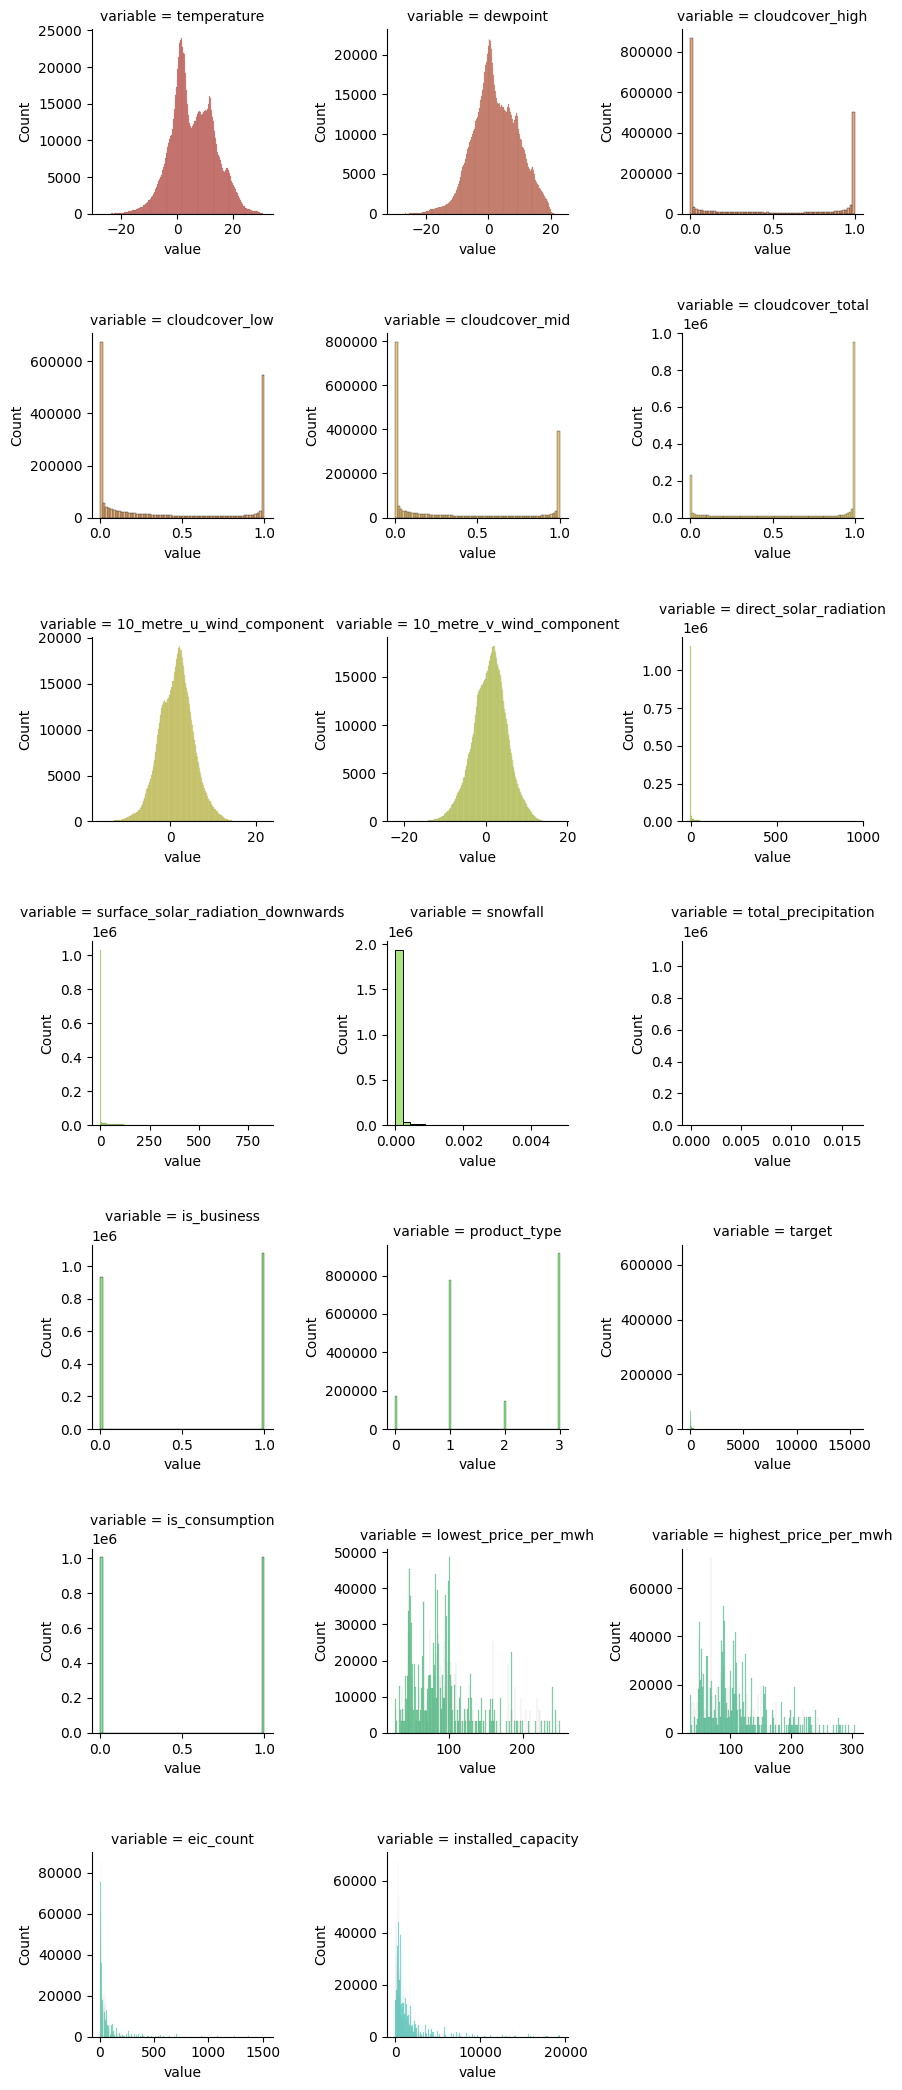

In [29]:
#What type of distribution law does each variable follow?

cols = df_train_forecast.drop(columns=[ 'latitude', 'longitude','county','row_id','origin_datetime',
                                        'date','hours_ahead','forecast_datetime',
                                        'forecast_date','origin_date','data_block_id','prediction_unit_id']).columns

# Conversion des infinis en NaN
df = df_train_forecast[cols].replace([np.inf, -np.inf], np.nan)

#cols = df_train_forecast.select_dtypes(include=np.number).columns
f = pd.melt(df, value_vars = cols)
g = sns.FacetGrid(f, col = 'variable',col_wrap=3, sharex=False, sharey=False)


for ax, col, color in zip(g.axes.flat,cols , sns.color_palette("hls", 40)):
    sns.histplot(data=f[f['variable'] == col], x='value', ax=ax, color=color)

# Ajustement des espacements
g.fig.tight_layout(w_pad=2, h_pad=3)

# Affichage du graphique
plt.show()

### Interprétation des Graphiques

#### Température
- La température semble suivre une distribution normale avec une moyenne autour de 0.
- **Distribution en forme de cloche** : Indique que les températures sont symétriquement distribuées autour de la moyenne.
- Cela est typique d'une distribution normale.

#### Point de Rosée
- **Distribution en forme de cloche**, similaire à la température.
- Indique une distribution symétrique autour de la moyenne.

#### Couverture Nuageuse
- **Cloudcover_low, Cloudcover_mid, Cloudcover_high, Cloudcover_total** :
  - Distributions fortement asymétriques avec des pics à 0 et 1.
  - Cela indique que la couverture nuageuse est souvent soit totalement absente (0) soit complète (1), avec peu de valeurs intermédiaires.

#### Composantes du Vent
- **10_metre_u_wind_component, 10_metre_v_wind_component** :
  - Distributions symétriques centrées autour de 0.
  - Suggère que les composantes du vent suivent une distribution normale, avec des valeurs positives et négatives autour de la moyenne.

#### Rayonnement Solaire
- **Direct_solar_radiation, Surface_solar_radiation_downwards** :
  - Distributions asymétriques avec des pics à de faibles valeurs.
  - Indique que la plupart des valeurs de rayonnement solaire sont faibles, avec quelques valeurs plus élevées.

#### Précipitations Totales
- Distribution fortement asymétrique avec la plupart des valeurs proches de 0.
- Indique que les précipitations sont souvent nulles ou très faibles, avec quelques occurrences de fortes précipitations.

### Interprétation des Résultats

#### Rayonnement Solaire de Surface Vers le Bas
- **Distribution** : La distribution est extrêmement asymétrique, avec la plupart des valeurs très proches de zéro et quelques valeurs beaucoup plus élevées.
- **Interprétation** : Cela suggère que la plupart du temps, le rayonnement solaire de surface est faible, mais il y a des occasions où il atteint des niveaux très élevés.

#### Chutes de Neige
- **Distribution** : La distribution montre que presque toutes les valeurs de chute de neige sont très proches de zéro, avec quelques valeurs légèrement plus élevées.
- **Interprétation** : Les chutes de neige sont très rares dans l'ensemble de données, avec la majorité des jours ayant peu ou pas de neige.

#### Précipitations Totales
- **Distribution** : Distribution extrêmement asymétrique, similaire au rayonnement solaire, avec la plupart des valeurs proches de zéro et quelques valeurs beaucoup plus élevées.
- **Interprétation** : La plupart du temps, les précipitations totales sont faibles, mais il y a des événements occasionnels de fortes précipitations.

#### Est-ce une Entreprise ?
- **Distribution** : Distribution binaire avec des valeurs principalement à 0 et 1.
- **Interprétation** : Cela indique que cette variable est probablement une variable catégorielle indiquant si l'entité est une entreprise ou non.

#### Type de Produit
- **Distribution** : Les valeurs sont principalement réparties entre les catégories 0, 1, 2 et 3.
- **Interprétation** : Cela montre que cette variable est catégorielle et que différents types de produits sont représentés dans l'ensemble de données.

#### Cible
- **Distribution** : Distribution extrêmement asymétrique avec la plupart des valeurs proches de zéro et quelques valeurs beaucoup plus élevées.
- **Interprétation** : Cela indique que la cible (probablement la variable dépendante dans votre modèle) a de nombreux cas avec des valeurs faibles et quelques cas avec des valeurs très élevées.

#### Consommation
- **Distribution** : Distribution binaire similaire à la variable "Est-ce une Entreprise ?".
- **Interprétation** : Cela indique que cette variable est également catégorielle, probablement indiquant si l'entité consomme de l'énergie ou non.

#### Prix le Plus Bas par MWh
- **Distribution** : Distribution relativement uniforme avec une concentration de valeurs autour de 100.
- **Interprétation** : Le prix le plus bas par MWh est généralement autour de 100, avec une certaine variabilité.

#### Prix le Plus Élevé par MWh
- **Distribution** : Distribution similaire au prix le plus bas mais avec des valeurs plus élevées et une plus grande variabilité.
- **Interprétation** : Le prix le plus élevé par MWh a une moyenne plus élevée et est plus variable, indiquant de plus grandes fluctuations.

### Conclusion
Ces distributions montrent que certaines variables sont fortement asymétriques, ce qui pourrait nécessiter des transformations (comme une transformation logarithmique) avant de les utiliser dans des modèles prédictifs. Les variables catégorielles (comme "Est-ce une Entreprise ?" et "Type de Produit") doivent être traitées de manière appropriée pour les modèles de machine learning.


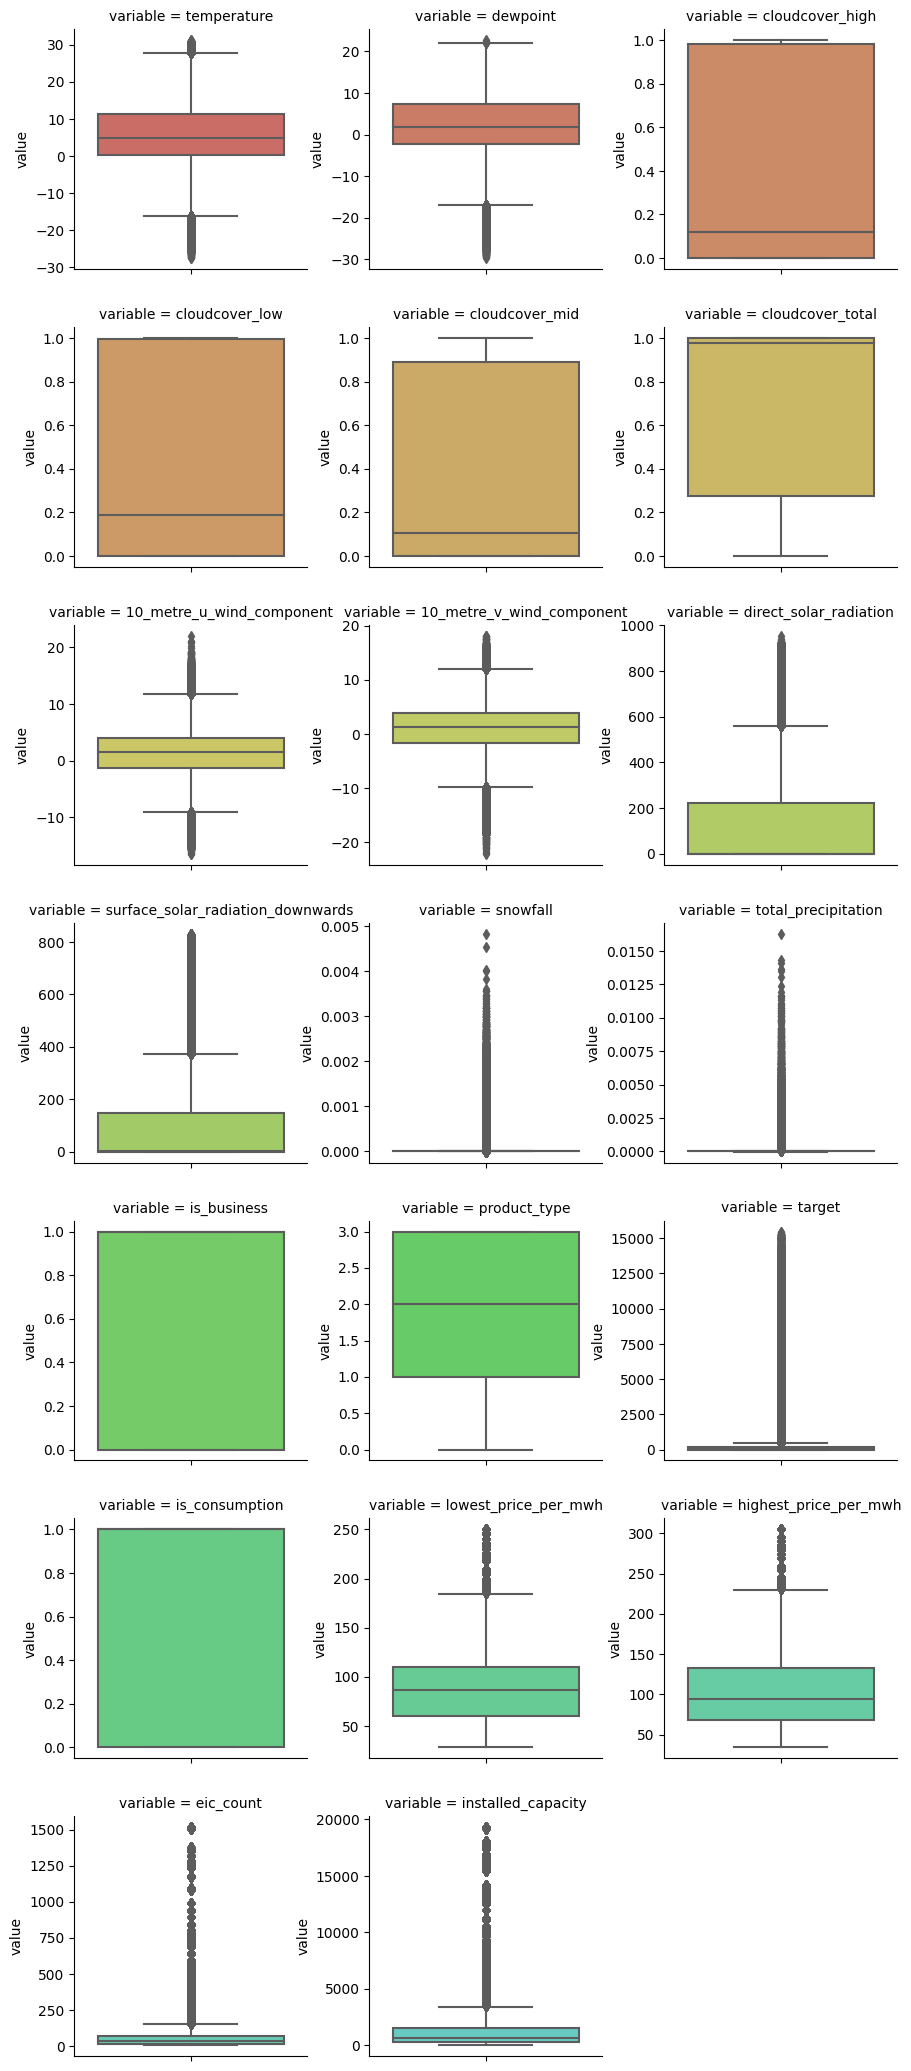

In [41]:
f = pd.melt(df_train_forecast[cols], value_vars = cols)
g = sns.FacetGrid(f, col = 'variable',col_wrap=3, sharex=False, sharey=False)


for ax, col, color in zip(g.axes.flat,cols , sns.color_palette("hls", 40)):
    sns.boxplot(data=f[f['variable'] == col], y='value', ax=ax, color=color)

### Interprétation des Boxplots

#### Température
- **Distribution** : La température semble suivre une distribution normale avec une moyenne autour de 0.
- **Quartiles** :
  - Premier quartile (Q1) : environ 1,5 degrés.
  - Médiane : environ 6 degrés.
  - Troisième quartile (Q3) : environ 11 degrés.
- **Extrêmes** : Les valeurs varient de -30 à 31 degrés.

#### Point de Rosée
- **Distribution** : Semblable à la température, suggérant une distribution normale.
- **Quartiles** :
  - Premier quartile (Q1) : environ 0 degrés.
  - Médiane : environ 5 degrés.
  - Troisième quartile (Q3) : environ 10 degrés.
- **Extrêmes** : Les valeurs varient de -30 à 21 degrés.

#### Couverture Nuageuse
- **Cloudcover_low, Cloudcover_mid, Cloudcover_high, Cloudcover_total** :
  - **Distribution** : Fortement asymétrique avec des pics à 0 et 1.
  - **Interprétation** : Indique que la couverture nuageuse est souvent soit totalement absente (0) soit totale (1), avec peu de valeurs intermédiaires.

#### Composantes du Vent
- **10_metre_u_wind_component, 10_metre_v_wind_component** :
  - **Distribution** : Symétrique autour de 0.
  - **Quartiles** :
    - Premier quartile (Q1) : environ -2.
    - Médiane : environ 0.
    - Troisième quartile (Q3) : environ 2.
  - **Interprétation** : Suggère que les composantes du vent ont une distribution normale, avec des valeurs positives et négatives autour de la moyenne.

#### Rayonnement Solaire
- **Direct_solar_radiation, Surface_solar_radiation_downwards** :
  - **Distribution** : Très asymétrique.
  - **Quartiles** :
    - Premier quartile (Q1) : environ 50 pour Surface Solar Radiation Downwards.
    - Médiane : environ 100 pour Surface Solar Radiation Downwards.
    - Troisième quartile (Q3) : environ 200 pour Surface Solar Radiation Downwards.
  - **Extrêmes** : Des valeurs extrêmes allant jusqu'à environ 850 pour Direct Solar Radiation.

#### Précipitations Totales et Chutes de Neige
- **Total Precipitation, Snowfall** :
  - **Distribution** : Très asymétrique.
  - **Quartiles** :
    - Premier quartile (Q1) : environ 0.
    - Médiane : environ 0.
    - Troisième quartile (Q3) : environ 0.001 pour Total Precipitation.
  - **Extrêmes** : De nombreux outliers au-dessus de 0.001 pour Total Precipitation, allant jusqu'à environ 0.015.

#### Is Business
- **Distribution** : Variable binaire.
- **Valeurs** : 0 et 1.
- **Interprétation** : Indique si l'entité est une entreprise ou non.

#### Product Type
- **Distribution** : Variable catégorielle.
- **Quartiles** :
  - Premier quartile (Q1) : environ 1.
  - Médiane : environ 2.
  - Troisième quartile (Q3) : environ 2.5.
- **Interprétation** : Montre les différents types de produits.

#### Target
- **Distribution** : Très asymétrique.
- **Quartiles** :
  - Premier quartile (Q1) : environ 0.
  - Médiane : environ 0.
  - Troisième quartile (Q3) : environ 0.
- **Extrêmes** : De nombreux outliers au-dessus de 0, allant jusqu'à environ 15000.

#### Is Consumption
- **Distribution** : Variable binaire.
- **Valeurs** : 0 et 1.
- **Interprétation** : Indique si l'entité est un consommateur ou un producteur.

#### Lowest Price Per MWh
- **Distribution** : Relativement uniforme avec une concentration des valeurs autour de 100.
- **Quartiles** :
  - Premier quartile (Q1) : environ 75.
  - Médiane : environ 100.
  - Troisième quartile (Q3) : environ 150.
- **Extrêmes** : De nombreux outliers au-dessus de 150, allant jusqu'à environ 250.

#### Highest Price Per MWh
- **Distribution** : Similaire à la variable "lowest_price_per_mwh", mais avec des valeurs plus élevées.
- **Quartiles** :
  - Premier quartile (Q1) : environ 100.
  - Médiane : environ 150.
  - Troisième quartile (Q3) : environ 200.
- **Extrêmes** : De nombreux outliers au-dessus de 200, allant jusqu'à environ 300.

#### EIC Count
- **Distribution** : Très asymétrique.
- **Quartiles** :
  - Premier quartile (Q1) : environ 50.
  - Médiane : environ 100.
  - Troisième quartile (Q3) : environ 200.
- **Extrêmes** : De nombreux outliers au-dessus de 200, allant jusqu'à environ 1500.

#### Installed Capacity
- **Distribution** : Très asymétrique.
- **Quartiles** :
  - Premier quartile (Q1) : environ 500.
  - Médiane : environ 1000.
  - Troisième quartile (Q3) : environ 2000.
- **Extrêmes** : De nombreux outliers au-dessus de 2000, allant jusqu'à environ 20000.

### Conclusion
Ces boxplots montrent que :
- Les variables "surface_solar_radiation_downwards", "snowfall", et "total_precipitation" présentent une forte asymétrie avec des valeurs principalement proches de zéro et quelques valeurs très élevées.
- Les variables binaires "is_business" et "is_consumption" sont correctement représentées avec des valeurs distinctes 0 et 1.
- La variable "product_type" montre une distribution catégorielle avec plusieurs types de produits.
- La variable "target" présente une forte asymétrie avec de nombreux outliers.
- Les variables "lowest_price_per_mwh" et "highest_price_per_mwh" montrent des distributions relativement uniformes avec des valeurs plus élevées pour "highest_price_per_mwh".
- Les variables "eic_count" et "installed_capacity" montrent une forte asymétrie avec de nombreux outliers.

Ces observations suggèrent que certaines variables peuvent nécessiter des transformations pour être utilisées efficacement dans des modèles prédictifs. Par exemple, les transformations logarithmiques pourraient être utiles pour les variables de rayonnement solaire et de précipitations totales pour réduire leur asymétrie.

    - 

# 2.3 features engineering

In [29]:
cols = df_train_forecast.drop(columns=[ 'latitude', 'longitude','county','row_id','origin_datetime',
                                        'date','hours_ahead','forecast_datetime',
                                        'forecast_date','origin_date','data_block_id','prediction_unit_id']).columns


In [30]:
df_train_forecast_log = df_train_forecast[cols]

for column in cols:
    df_train_forecast_log[column] = np.log(df_train_forecast[column] + 1)

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_33/848313076.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_forecast_log[column] = np.log(df_train_forecast[column] + 1)


In [31]:
def new_features(df_features):
    
        df_features["hour"] = df_features["datetime"].dt.hour
        df_features["day"] = df_features["datetime"].dt.day
        df_features["weekday"] = df_features["datetime"].dt.weekday
        df_features["month"] = df_features["datetime"].dt.month
        df_features["year"] = df_features["datetime"].dt.year
        df_features["dayofyear"] = df_features["datetime"].dt.dayofyear
        
        # Ajouter les colonnes sinusoïdales pour capturer la cyclicité
        df_features["sin_dayofyear"] = np.sin(np.pi * df_features["dayofyear"] / 183)
        df_features["cos_dayofyear"] = np.cos(np.pi * df_features["dayofyear"] / 183)
        df_features["sin_hour"] = np.sin(np.pi * df_features["hour"] / 12)
        df_features["cos_hour"] = np.cos(np.pi * df_features["hour"] / 12)
        
        return df_features

In [32]:
df_train_forecast['datetime'] = df_train_forecast.index
df_train_forecast2 = new_features(df_train_forecast)
cols = df_train_forecast2.drop(columns=['latitude', 'longitude','county','row_id','origin_datetime',
                                        'date','hours_ahead','forecast_datetime','datetime',
                                        'forecast_date','origin_date','data_block_id','prediction_unit_id']).columns
cols

Index(['temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component',
       '10_metre_v_wind_component', 'direct_solar_radiation',
       'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation',
       'is_business', 'product_type', 'target', 'is_consumption',
       'lowest_price_per_mwh', 'highest_price_per_mwh', 'eic_count',
       'installed_capacity', 'hour', 'day', 'weekday', 'month', 'year',
       'dayofyear', 'sin_dayofyear', 'cos_dayofyear', 'sin_hour', 'cos_hour'],
      dtype='object')

In [94]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

X = sm.add_constant(df_train_forecast2[cols])
# Sélectionner les colonnes pertinentes pour le calcul du VIF
X = X.drop(columns='target')
# constante pour le calcul du VIF
X = sm.add_constant(X)

# Calcule le VIF pour chaque variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                             Variable           VIF
0                               const  2.093972e+07
1                         temperature  1.555873e+01
2                            dewpoint  1.224518e+01
3                     cloudcover_high  2.135151e+00
4                      cloudcover_low  2.616576e+00
5                      cloudcover_mid  1.695410e+00
6                    cloudcover_total  3.584110e+00
7           10_metre_u_wind_component  1.163267e+00
8           10_metre_v_wind_component  1.185995e+00
9              direct_solar_radiation  6.739558e+00
10  surface_solar_radiation_downwards  6.916911e+00
11                           snowfall  1.377148e+00
12                total_precipitation  1.428372e+00
13                        is_business  1.314034e+00
14                       product_type  1.145104e+00
15                     is_consumption  1.000818e+00
16               lowest_price_per_mwh  2.947789e+01
17              highest_price_per_mwh  2.929307e+01
18          

In [95]:
df_train_forecast2[cols].describe().iloc[:,:20]

temperature      dewpoint  cloudcover_high  cloudcover_low  \
count  2.009182e+06  2.009182e+06     2.009182e+06    2.009182e+06   
mean   5.650304e+00  2.299228e+00     4.069380e-01    4.140792e-01   
std    7.835610e+00  7.153458e+00     4.459857e-01    4.352419e-01   
min   -2.749940e+01 -2.968357e+01     0.000000e+00    0.000000e+00   
25%    3.705078e-01 -2.339011e+00     0.000000e+00    3.051758e-05   
50%    4.853784e+00  1.745508e+00     1.199341e-01    1.891093e-01   
75%    1.132693e+01  7.384302e+00     9.841919e-01    9.974060e-01   
max    3.124551e+01  2.267642e+01     1.000008e+00    1.000008e+00   

       cloudcover_mid  cloudcover_total  10_metre_u_wind_component  \
count    2.009182e+06      2.009182e+06               2.009182e+06   
mean     3.583938e-01      6.834849e-01               1.420230e+00   
std      4.184010e-01      3.987929e-01               3.980333e+00   
min      0.000000e+00      0.000000e+00              -1.640865e+01   
25%      0.000000e+00      2.743681e-01              -1.255973e+00   
50%      1.062164e-01      9.750223e-01               1.580778e+00   
75%      8.916321e-01      9.999999e-01               3.979206e+00   
max      1.000008e+00      1.000008e+00               2.203584e+01   

       10_metre_v_wind_component  direct_solar_radiation  \
count               2.009182e+06            2.009182e+06   
mean                1.051695e+00            1.529315e+02   
std                 4.205041e+00            2.569409e+02   
min                -2.211612e+01           -7.733333e-01   
25%                -1.646978e+00            0.000000e+00   
50%                 1.244626e+00            0.000000e+00   
75%                 3.813584e+00            2.230671e+02   
max                 1.810218e+01            9.544222e+02   

       surface_solar_radiation_downwards      snowfall  total_precipitation  \
count                       2.009182e+06  2.009182e+06         2.009182e+06   
mean                        1.113336e+02  2.511451e-05         7.885371e-05   
std                         1.867650e+02  1.223377e-04         2.753147e-04   
min                        -3.258333e-01 -3.814697e-06        -1.529098e-05   
25%                         0.000000e+00  0.000000e+00         0.000000e+00   
50%                         6.320833e-01  0.000000e+00         0.000000e+00   
75%                         1.487529e+02  0.000000e+00         2.649799e-05   
max                         8.319411e+02  4.832983e-03         1.629448e-02   

        is_business  product_type        target  is_consumption  \
count  2.009182e+06  2.009182e+06  2.009182e+06       2009182.0   
mean   5.366980e-01  1.898971e+00  2.753079e+02             0.5   
std    4.986516e-01  1.082262e+00  9.107058e+02             0.5   
min    0.000000e+00  0.000000e+00  0.000000e+00             0.0   
25%    0.000000e+00  1.000000e+00  3.790000e-01             0.0   
50%    1.000000e+00  2.000000e+00  3.126400e+01             1.0   
75%    1.000000e+00  3.000000e+00  1.806220e+02             1.0   
max    1.000000e+00  3.000000e+00  1.548027e+04             1.0   

       lowest_price_per_mwh  highest_price_per_mwh     eic_count  \
count          2.009182e+06           2.009182e+06  2.009182e+06   
mean           9.556751e+01           1.084268e+02  7.342651e+01   
std            4.758057e+01           5.475296e+01  1.441307e+02   
min            2.810000e+01           3.400000e+01  5.000000e+00   
25%            6.000000e+01           6.769000e+01  1.400000e+01   
50%            8.600000e+01           9.400000e+01  3.200000e+01   
75%            1.097400e+02           1.330000e+02  7.000000e+01   
max            2.500000e+02           3.050000e+02  1.517000e+03   

       installed_capacity  
count        2.009182e+06  
mean         1.452350e+03  
std          2.423223e+03  
min          6.000000e+00  
25%          3.237000e+02  
50%          6.470800e+02  
75%          1.567150e+03  
max          1.931431e+04

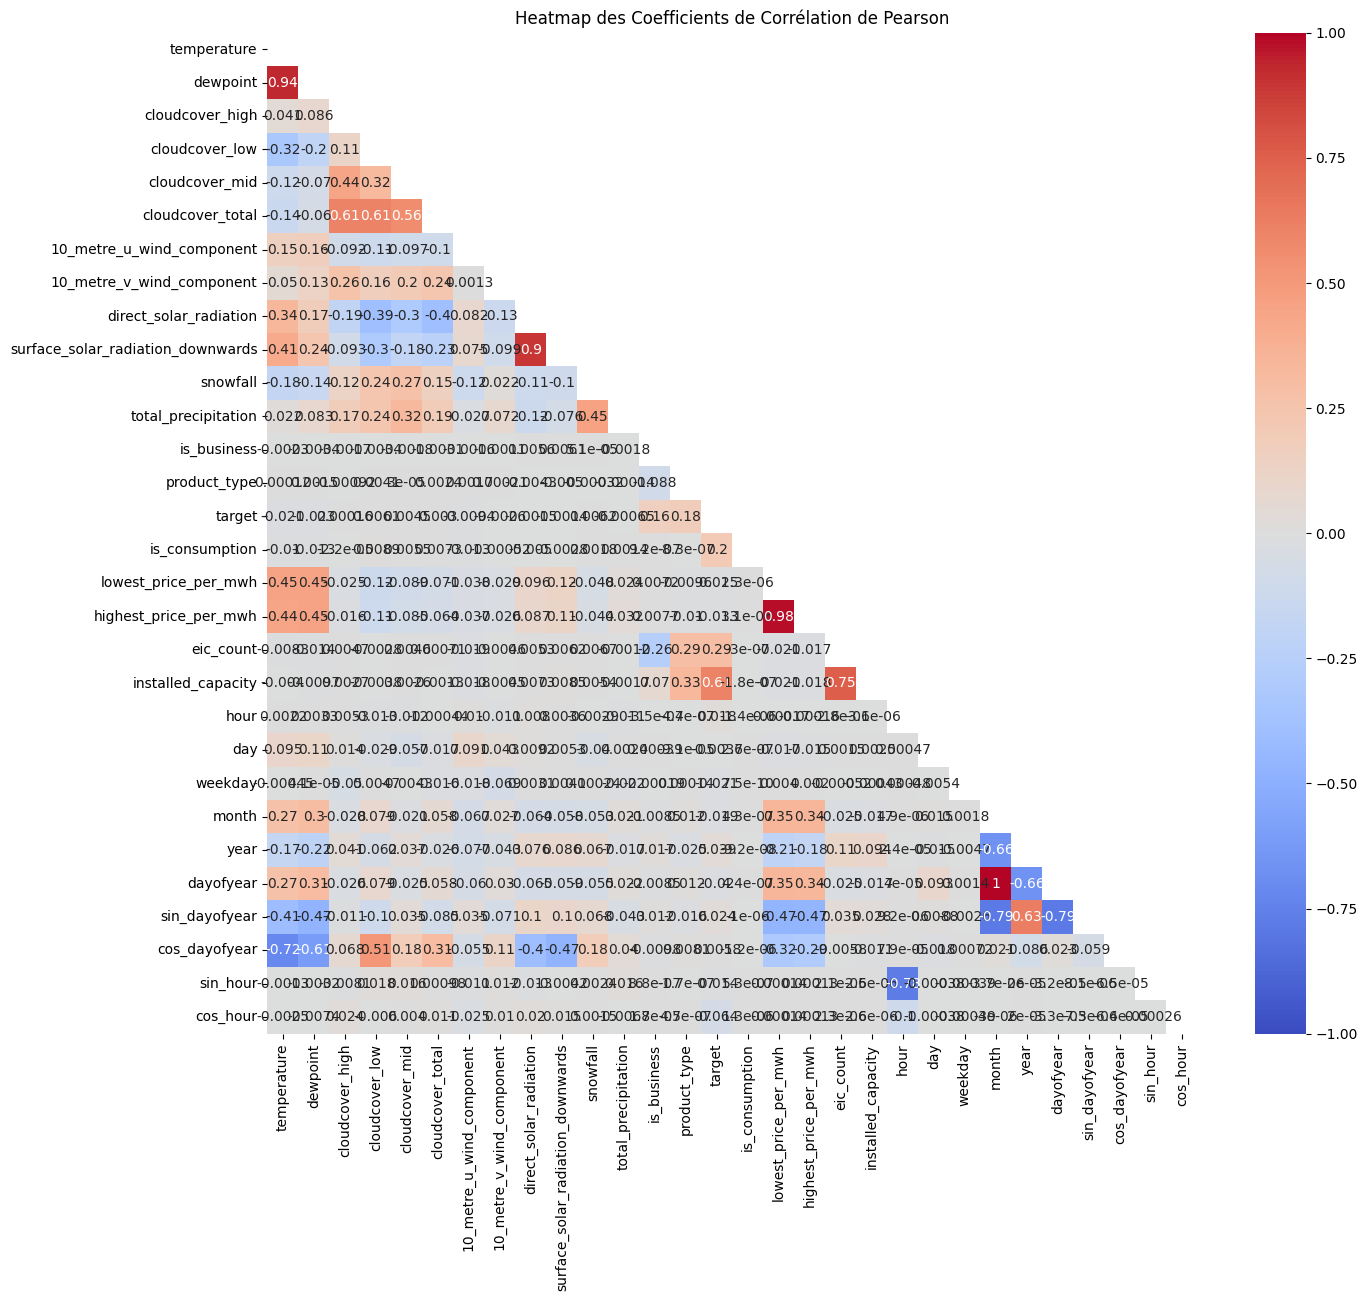

In [51]:
corr_matrix = df_train_forecast2[cols].corr(method='pearson')
# Créer une heatmap avec Seaborn
plt.figure(figsize=(15, 13))
mask = np.triu(corr_matrix)
sns.heatmap(data = corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask = mask)
plt.title('Heatmap des Coefficients de Corrélation de Pearson')
plt.show()

## Multicolinéarité

- **Variable Cible et Capacité Installée** : La variable cible a une corrélation de 0,61 avec la variable de capacité installée. Bien que cette corrélation soit modérée, elle n'est pas suffisamment forte pour suggérer des problèmes de multicolinéarité significatifs à elle seule.

- **Prix Minimum par MWh et Prix Maximum par MWh** : Les deux variables présentent des valeurs VIF élevées (27,37 et 27,09 respectivement), indiquant un degré très élevé de multicolinéarité entre ces deux variables. Cette forte colinéarité peut être problématique car elle peut gonfler les erreurs standard des coefficients et rendre les coefficients du modèle instables et moins interprétables.

- **Température et Point de Rosée** : La variable température a un VIF de 13,63 et la variable point de rosée a un VIF de 11,96. Ces valeurs VIF élevées suggèrent une multicolinéarité significative entre ces deux variables. Étant donné la forte corrélation entre la température et le point de rosée, il est conseillé de supprimer la variable point de rosée du modèle pour atténuer ce problème.


In [52]:
# the new variables is the addition of lowest and highest price per mwh variables 
df_train_forecast2['low_and_high_mean_price_mwh'] =  df_train_forecast2.highest_price_per_mwh - df_train_forecast2.lowest_price_per_mwh  

In [53]:
# i remove the variable dewpoint, lowest_price_per_mwh and, highest_price_per_mwh to avoid the colinearity
df_train_forecast2.drop(columns = ['dewpoint','lowest_price_per_mwh','highest_price_per_mwh'] , inplace=True)

# 3 Modelisation

## 3.1 Prediction de la variale target avec le modèle Sarimax

 - statistic test ADU (analyse if the serie is staionar)
 - analyse the autocorrelation and partial autocorrelation 
 - predict the value with the model Sarimax
 - conclusion about the prediction.

## 3.2 Prediction de la variale target avec le modèle Xgboost
  - Evaluation du MAE avec le modèle par défault
  - Optimlisation du modèle avec une recherche par grille des hyperparamètres
  - Eévaluation du MAE avce les paramètres retenu 
  
## 3.3 Prédiction de la variable target avec le réseau de neurone LSTM

 

# 3.1 Prediction de la variale target avec le modèle Sarimax

## Test statistique de stationnarité ADU

In [54]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

# H0 -> les données ne sont pas stationnaires 
# H1 -> les données sont stationnaires
# Vérifier la stationnarité initiale
result_adf = adfuller(df_train_forecast['target'].iloc[:100000])
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])

# Différencier la série si elle n'est pas stationnaire

# Vérifier la stationnarité après différenciation
result_adf_diff = adfuller(df_train_forecast['target'].diff(1).dropna().iloc[:100000])
print('ADF Statistic (diff):', result_adf_diff[0])
print('p-value (diff):', result_adf_diff[1])


ADF Statistic: -47.77838471730678
p-value: 0.0
ADF Statistic (diff): -47.630623412216025
p-value (diff): 0.0


## 

## Analyse series without differentiation

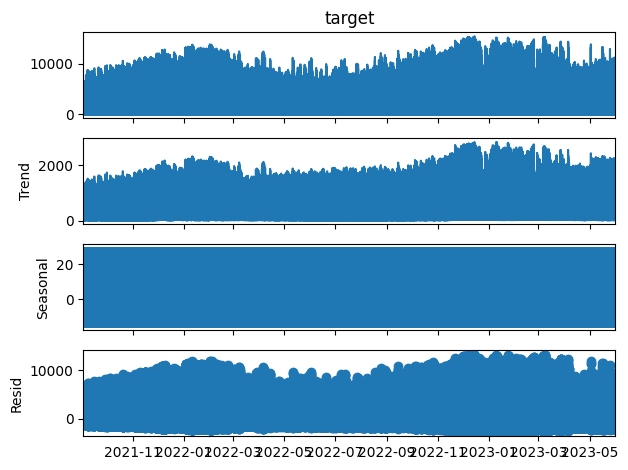

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Décomposition additive
result_add = seasonal_decompose(df_train_forecast['target'], model='additive', period=7)
result_add.plot()
plt.show()


In [100]:
trend = result_add.trend.loc[result_add.trend.index.year == 2022]
resid = result_add.resid.loc[result_add.resid.index.year == 2022]
season = result_add.seasonal.loc[result_add.seasonal.index.year == 2022]


print('residu var =',resid.var(),'residu mean', round(resid.mean(),4))

residu var = 686937.4399592725 residu mean -0.0


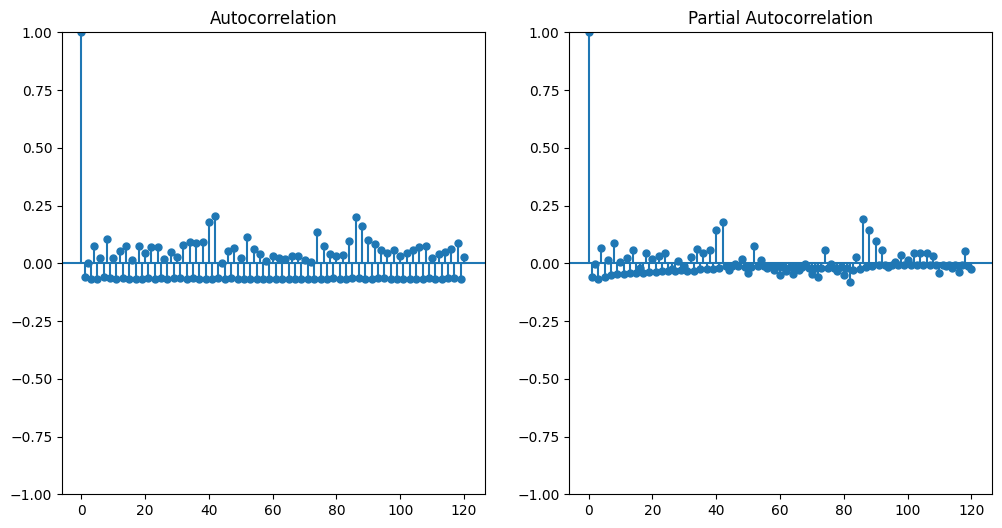

In [101]:
fig, ax = plt.subplots(1,2, figsize = (12,6))

plot_acf(df_train_forecast.target.iloc[:500000],lags=120,ax=ax[0])
plot_pacf(df_train_forecast.target.iloc[:500000],lags=120, ax=ax[1])

plt.show()

- In the autocorrelation graph, the value decreases at the first lag, but the confidence interval is very small. We cannot be sure that the prediction will be accurate for the real value.

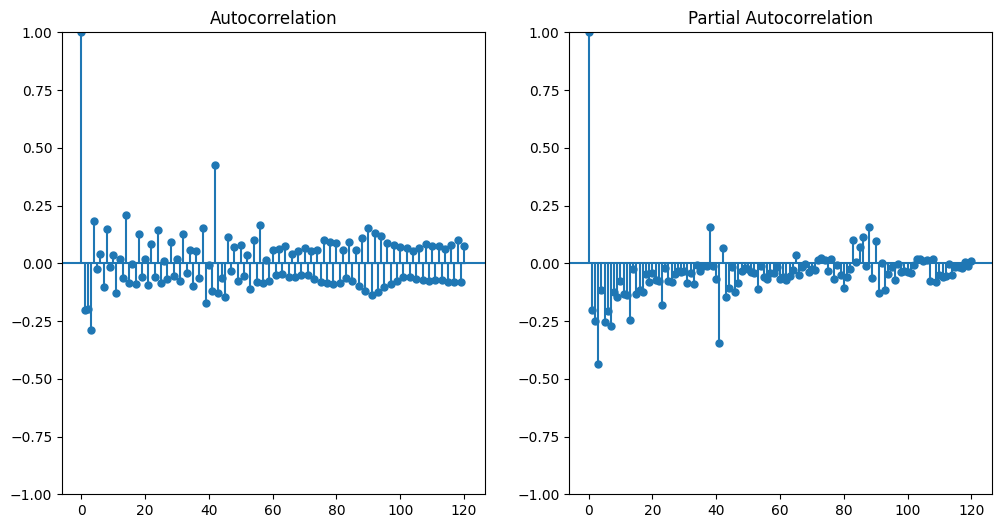

In [56]:
fig, ax = plt.subplots(1,2, figsize = (12,6))

plot_acf(resid[:500000],lags=120,ax=ax[0])
plot_pacf(resid[:500000],lags=120, ax=ax[1])

plt.show()

## Analyze ACF and PACF resid with 1 differianciation

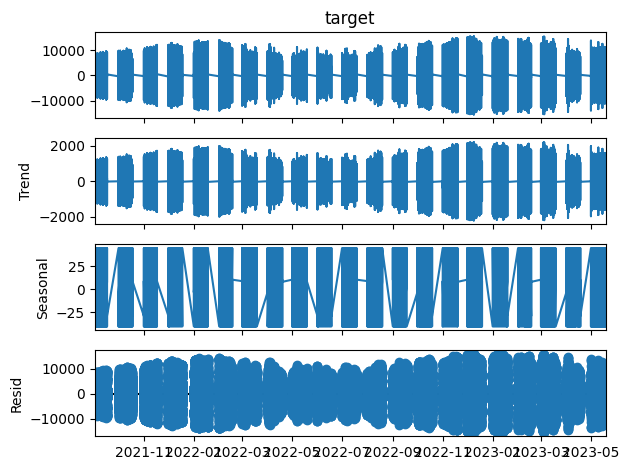

In [67]:
# Décomposition additive
result_add = seasonal_decompose(df_train_forecast['target'].diff(1).dropna(), model='additive', period=7)
result_add.plot()
plt.show()



In [68]:
trend = result_add.trend.loc[result_add.trend.index.year == 2022]
resid = result_add.resid.loc[result_add.resid.index.year == 2022]
season = result_add.seasonal.loc[result_add.seasonal.index.year == 2022]
season.shape

print('residu var =',resid.var(),'residu mean', round(resid.mean(),4))

residu var = 1659021.5741269917 residu mean 0.0001


In [69]:
df = df_train_forecast.loc[df_train_forecast.index.year == 2022, 'target'].iloc[:500000]
df.index = df.index.normalize()
df

datetime
2022-01-01      0.000
2022-01-01    442.226
2022-01-01      0.000
2022-01-01     44.899
2022-01-01      0.015
               ...   
2022-06-04     35.544
2022-06-04      6.223
2022-06-04    350.690
2022-06-04      1.001
2022-06-04    347.949
Name: target, Length: 500000, dtype: float64

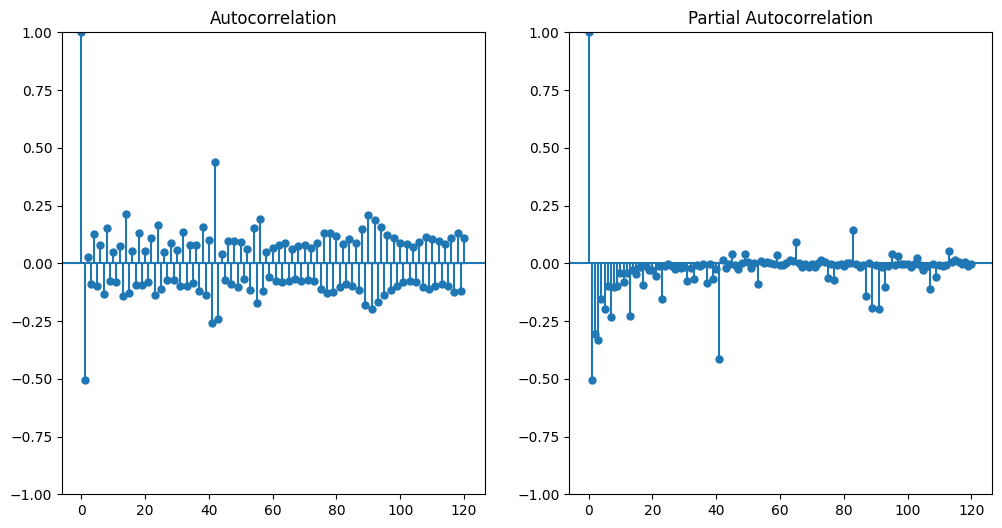

In [70]:


fig, ax = plt.subplots(1,2, figsize = (12,6))

plot_acf(df.diff(1).dropna(),lags=120,ax=ax[0])
plot_pacf(df.diff(1).dropna(),lags=120, ax=ax[1])

plt.show()


- In the autocorrelation graph, the model at the first lag shows a negative value that is outside the confidence interval. In the next lags, the values fluctuate between 0.10 and -0.10. We observe a strong peak at the 40th lag.
- In the partial autocorrelation graph, the model at the first lag shows a negative value. For the next lags, the values approach zero by the 20th lag. 


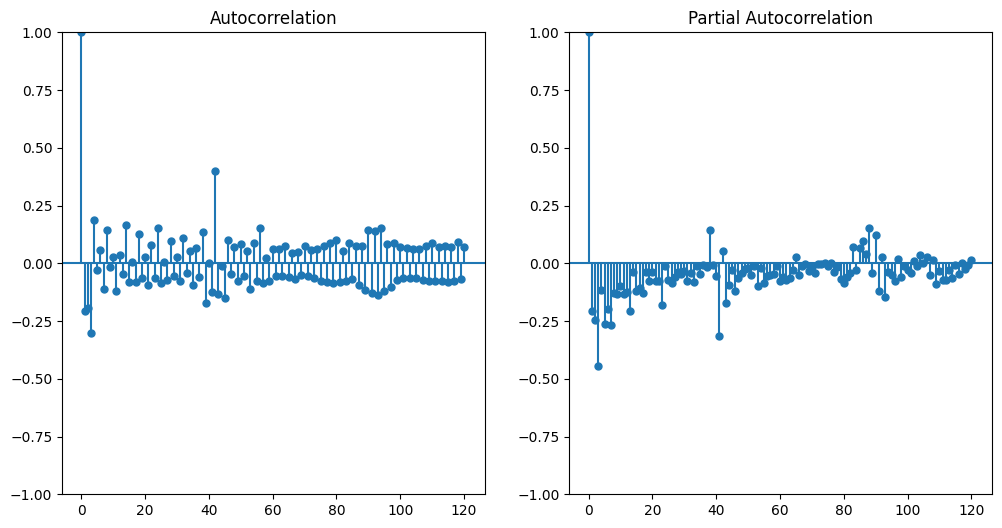

In [102]:
fig, ax = plt.subplots(1,2, figsize = (12,6))

plot_acf(resid,lags=120,ax=ax[0])
plot_pacf(resid,lags=120, ax=ax[1])

plt.show()


## Predict values with the model Sarima without differentiation (date 2022-01_01 à 2022-02-02) 

In [108]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX



# Ajouter des variables exogènes si disponibles (par exemple, température, radiation solaire)
endo_variables = df_train_forecast[['temperature','cloudcover_high', 'cloudcover_low','direct_solar_radiation', 'surface_solar_radiation_downwards']]
# Synchroniser les indices des variables exogènes avec les composantes de la série temporelle
endo_train = exog_variables.loc[exog_variables.index.year==2022].iloc[:100000]
endo_test = exog_variables.loc[exog_variables.index.year==2022].iloc[100000:110000]  # Par exemple, pour les 12 derniers mois

exog_train = df_train_forecast.target.loc[df_train_forecast.target.index.year == 2022].iloc[:100000]
exog_test = df_train_forecast.target.loc[df_train_forecast.target.index.year == 2022].iloc[100000:110000]


# Utiliser les composantes pour la modélisation
# Séparation des données en ensemble d'entraînement et de testdf_train_forecast.diff(7).dropna()iloc[:500000]
# Prédictions sur la tendance
# Utiliser un modèle SARIMAX avec une saisonnalité ajustée
try:
    model = SARIMAX(exog_train,
                    order=(1, 0, 1), 
                    seasonal_order=(1, 0, 1, 7),  # Saisonnalité réduite à 7 jours
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    
    
    fit = model.fit(disp=False)
    print(fit.summary())

except MemoryError as e:
    print(f"MemoryError: {e}")

except Exception as e:
    print(f"Error: {e}")



/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                            target   No. Observations:               100000
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood             -833686.926
Date:                           Sat, 06 Jul 2024   AIC                        1667383.851
Time:                                   20:44:10   BIC                        1667431.416
Sample:                                        0   HQIC                       1667398.286
                                        - 100000                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5576      0.093      6.002      0.000       0.376       0.740
ma.L1         -0.6139      0.089     -6.921

In [109]:
forecast_test = fit.forecast(steps=exog_test.shape[0])
forecast_test

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


100000    279.888101
100001    269.562483
100002    263.705312
100003    261.363189
100004    260.410481
             ...    
109995    256.235932
109996    257.806850
109997    256.791508
109998    256.126050
109999    256.675038
Name: predicted_mean, Length: 10000, dtype: float64

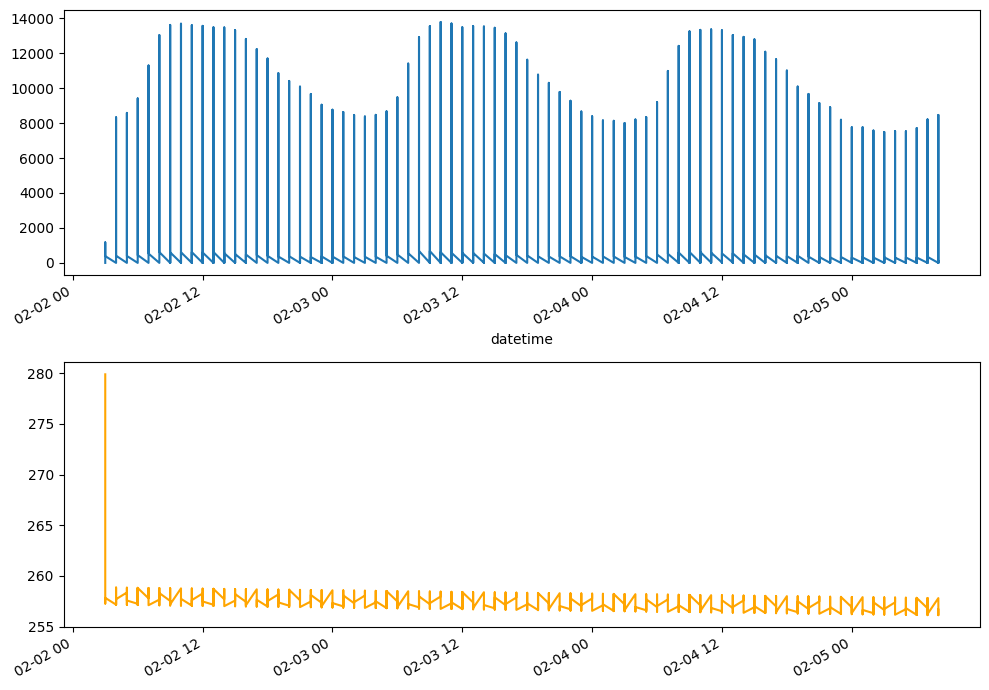

In [110]:
df_fore = pd.Series(data=forecast_test.values, index=exog_test.index.values)
fig,ax = plt.subplots(2,1,figsize=(10,7))
#exog_train.plot(ax=ax[0])
exog_test.plot(ax=ax[0])
df_fore.plot(ax=ax[1], color='orange')

plt.tight_layout()
plt.show()

In [111]:
#display(pd.concat([df_fore, test_trend], axis=1))
mse = np.sqrt(mean_squared_error(forecast_test, exog_test))
print(f'MSE: {mse}')

MSE: 1117.8903526224437


## Predict values with Sarima with 1 differianciation (date 2022-01_01 à 2022-02-02) 

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX



# Ajouter des variables exogènes si disponibles (par exemple, température, radiation solaire)
exog_variables = df_train_forecast[['temperature','cloudcover_high', 'cloudcover_low','direct_solar_radiation', 'surface_solar_radiation_downwards']]
# Synchroniser les indices des variables exogènes avec les composantes de la série temporelle
exog_train = exog_variables.loc[exog_variables.index.year==2022].iloc[:100000]
exog_test = exog_variables.loc[exog_variables.index.year==2022].iloc[100000:110000]  # Par exemple, pour les 12 derniers mois

endo_train = df_train_forecast.target.loc[df_train_forecast.target.index.year == 2022].iloc[:100000]
endo_test = df_train_forecast.target.loc[df_train_forecast.target.index.year == 2022].iloc[100000:110000]


# Utiliser les composantes pour la modélisation
# Séparation des données en ensemble d'entraînement et de testdf_train_forecast.diff(7).dropna()iloc[:500000]
# Prédictions sur la tendance
# Utiliser un modèle SARIMAX avec une saisonnalité ajustée
try:
    model = SARIMAX(endo_train,
                    order=(1, 1, 1), 
                    seasonal_order=(1, 1, 1, 7),  # Saisonnalité réduite à 7 jours
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    
    
    fit = model.fit(disp=False)
    print(fit.summary())

except MemoryError as e:
    print(f"MemoryError: {e}")

except Exception as e:
    print(f"Error: {e}")



/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                            target   No. Observations:               100000
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood             -851123.732
Date:                           Thu, 11 Jul 2024   AIC                        1702257.465
Time:                                   18:19:37   BIC                        1702305.028
Sample:                                        0   HQIC                       1702271.899
                                        - 100000                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0598      0.025     -2.355      0.019      -0.110      -0.010
ma.L1         -0.9989      0.000  -2114.634

In [153]:
forecast_test = fit.forecast(steps=endo_test.shape[0])
forecast_test

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


99960     234.950709
99961     287.374478
99962     287.064184
99963     286.850859
99964     282.105674
             ...    
109955    275.157603
109956    274.978265
109957    276.125072
109958    277.016047
109959    275.343388
Name: predicted_mean, Length: 10000, dtype: float64

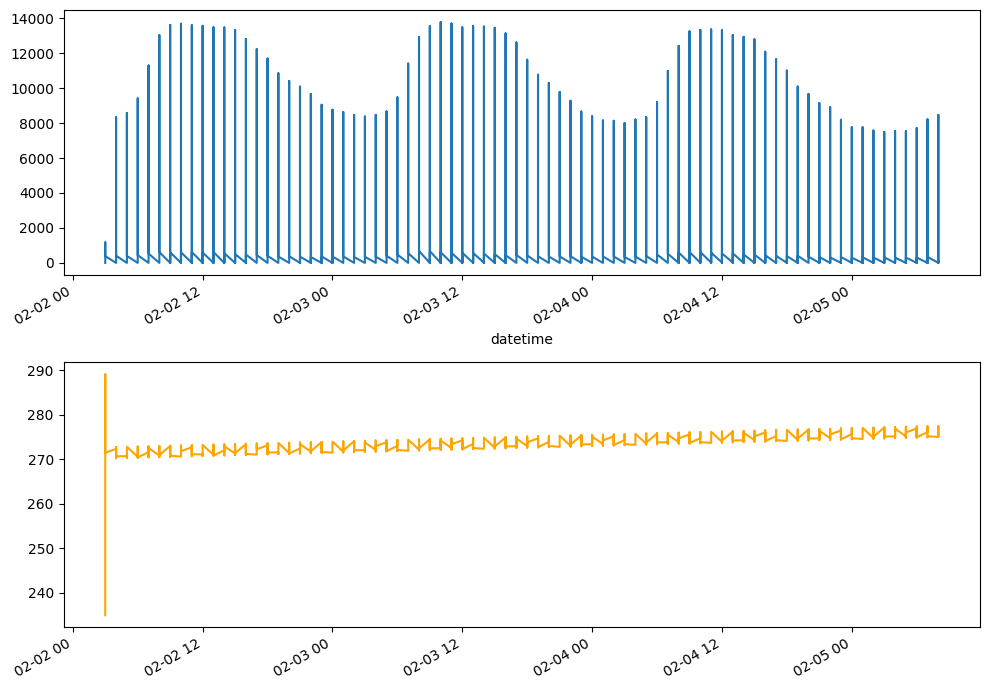

In [154]:
df_fore = pd.Series(data=forecast_test.values, index=exog_test.index.values)
fig,ax = plt.subplots(2,1,figsize=(10,7))
#exog_train.plot(ax=ax[0])
exog_test.plot(ax=ax[0])
df_fore.plot(ax=ax[1], color='orange')

plt.tight_layout()
plt.show()

In [122]:
#display(pd.concat([df_fore, test_trend], axis=1))
mse = np.sqrt(mean_squared_error(forecast_test, endo_test))
print(f'MSE: {mse}')

MSE: 1117.408410447193


## Predict values with Sarima with features lags (date 2022-01_01 à 2022-02-02)  

In [33]:
# Exemple de création de variables retardées

endo_train = df_train_forecast.target.loc[df_train_forecast.target.index.year == 2022].iloc[:100000]
endo_test = df_train_forecast.target.loc[df_train_forecast.target.index.year == 2022].iloc[100000:110000]

def create_lagged_features(df, target,lags):
    for lag in lags:
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)
    return df

lags = [1, 2, 3, 7, 14, 40] 
X_train = create_lagged_features(pd.DataFrame(endo_train),'target',lags=lags)
X_train.dropna(inplace=True)
X_test = create_lagged_features(pd.DataFrame(endo_test),'target',lags=lags)
X_test.dropna(inplace=True)


In [34]:
X_train.drop(columns='target', inplace=True)
X_test.drop(columns='target', inplace=True)


In [35]:
y_test_reset = endo_test.iloc[:X_test.shape[0]].reset_index(drop=True)
X_test_reset = X_test.reset_index(drop=True)

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Utiliser un modèle SARIMAX avec une saisonnalité ajustée
try:
    model = SARIMAX(
                    endog=y_train_reset,
                    order=(1, 1, 1), 
                    seasonal_order=(1, 1, 1, 7),  # Saisonnalité réduite à 7 jours
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    
    
    fit = model.fit(disp=False)
    print(fit.summary())

except MemoryError as e:
    print(f"MemoryError: {e}")

except Exception as e:
    print(f"Error: {e}")



Error: name 'y_train_reset' is not defined


In [223]:
forecast_test = fit.forecast(steps=y_test_reset.shape[0])


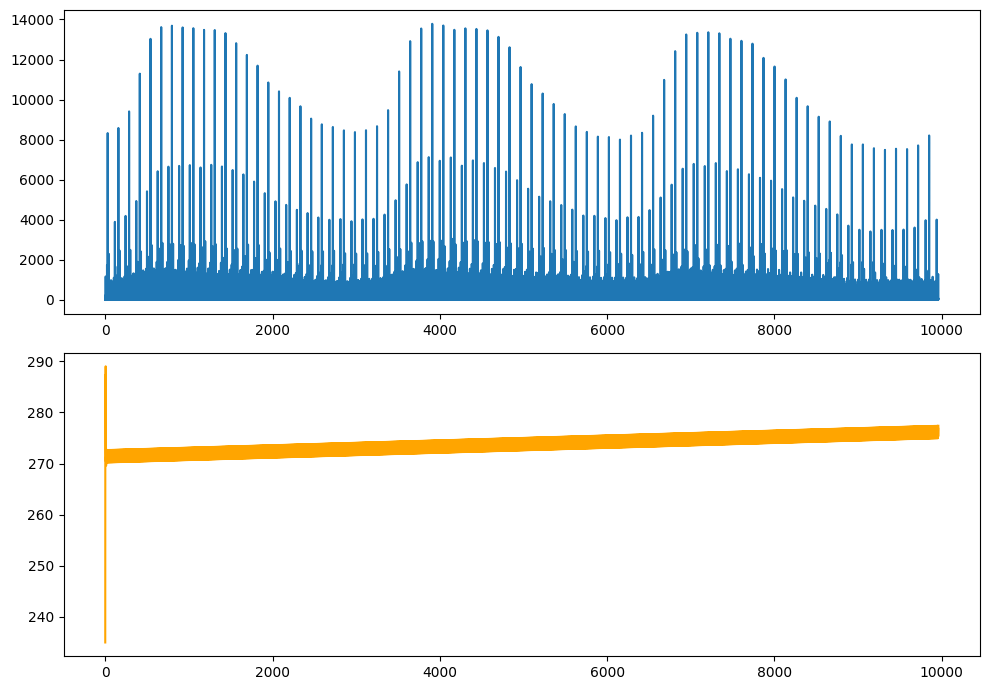

In [224]:
df_fore = pd.Series(data=forecast_test.values, index=y_test_reset.index)
fig,ax = plt.subplots(2,1,figsize=(10,7))
y_test_reset.plot(ax=ax[0])
df_fore.plot(ax=ax[1], color='orange')
plt.tight_layout()

In [225]:
mse = np.sqrt(mean_squared_error(forecast_test , y_test_reset))
print(f'MSE: {mse}')

MSE: 1116.3313739179914


# 3.2 Prediction de la variale target avec le modèle Xgboost

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

In [39]:
cols = df_train_forecast2.drop(columns=[ 'latitude', 'longitude','county','row_id','origin_datetime',
                                        'date','hours_ahead','forecast_datetime','datetime',
                                        'forecast_date','origin_date','data_block_id','prediction_unit_id']).columns
cols

Index(['temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component',
       '10_metre_v_wind_component', 'direct_solar_radiation',
       'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation',
       'is_business', 'product_type', 'target', 'is_consumption',
       'lowest_price_per_mwh', 'highest_price_per_mwh', 'eic_count',
       'installed_capacity', 'hour', 'day', 'weekday', 'month', 'year',
       'dayofyear', 'sin_dayofyear', 'cos_dayofyear', 'sin_hour', 'cos_hour'],
      dtype='object')

In [40]:

# Synchroniser les indices des variables exogènes avec les composantes de la série temporelle
X_train = df_train_forecast2.loc[(df_train_forecast2.index.year>=2021)&(df_train_forecast2.index.year<=2022), cols]
X_test = df_train_forecast2.loc[(df_train_forecast2.index.year==2023), cols]
# Utiliser les composantes pour la modélisation
# Séparation des données en ensemble d'entraînement et de test
y_train = df_train_forecast2.target.loc[(df_train_forecast2.index.year>=2021)&(df_train_forecast2.index.year<=2022)]
y_test = df_train_forecast2.target.loc[(df_train_forecast2.target.index.year == 2023)]



In [41]:

# Exemple de création de variables retardées
def create_lagged_features(df, target,lags):
    for lag in lags:
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)
    return df

lags = [1, 2, 3, 7, 14, 40] 
X_train_lag = create_lagged_features(X_train,'target',lags=lags)
X_train_lag.dropna(inplace=True)
X_test_lag = create_lagged_features(X_test,'target',lags=lags)
X_test_lag.dropna(inplace=True)

In [42]:
X_train_lag.drop(columns='target',inplace=True)
X_test_lag.drop(columns='target',inplace=True)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:22:38] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


temps d execution :  19.11758017539978
RMSE: 351.5488065536511


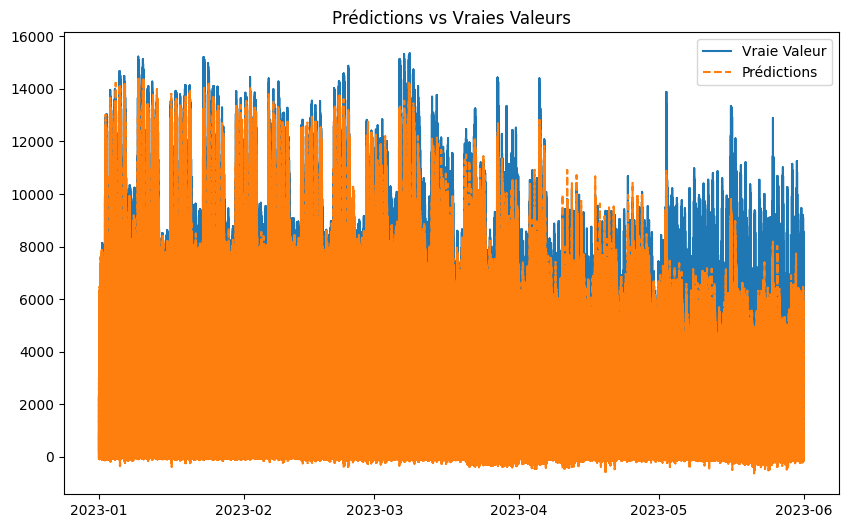

In [43]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import time

t1 = time.time()
# Créer et entraîner le modèle XGBoost
model = XGBRegressor(objective='reg:squarederror',tree_method='hist', device='cuda')
model.fit(X_train_lag, y_train[40:])
t2 = time.time()
print('temps d execution : ', (t2-t1))
# Faire des prédictions
y_pred = model.predict(X_test_lag)

# Calculer l'erreur quadratique moyenne
rmse = np.sqrt(mean_squared_error(y_test[40:], y_pred))
print(f'RMSE: {rmse}')

# Meilleurs paramètres trouvés : {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6}
# Meilleurs paramètres trouvés : {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6}

plt.figure(figsize=(10, 6))
plt.plot(y_test.index[40:], y_test[40:], label='Vraie Valeur')
plt.plot(y_test.index[40:], y_pred, label='Prédictions', linestyle='--')
plt.legend()
plt.title('Prédictions vs Vraies Valeurs')
plt.show()


In [44]:
# récupère la consommation et la production du mois de février 2023
X_test2 = df_train_forecast2.loc[(df_train_forecast2.index.year==2023)&(df_train_forecast2.target.index.month == 2), cols]
y_test2 = df_train_forecast2.target.loc[(df_train_forecast2.target.index.year == 2023)&(df_train_forecast2.target.index.month == 2)]

X_test2_lag = create_lagged_features(X_test2,'target',lags=lags)
X_test2_lag.dropna(inplace=True)

X_test2_lag.drop(columns=['target'],inplace=True)

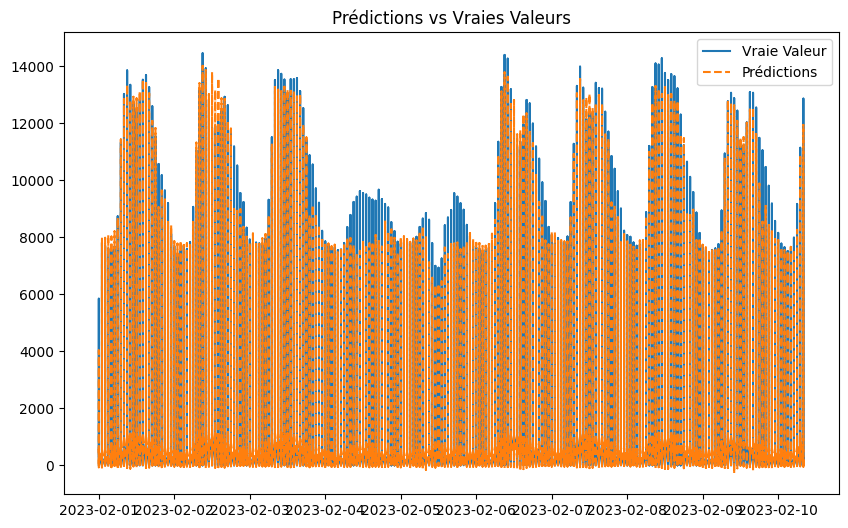

In [45]:
# Faire des prédictions
y_pred = model.predict(X_test2_lag)


plt.figure(figsize=(10, 6))
plt.plot(y_test2[40:30000].index, y_test2[40:30000], label='Vraie Valeur')
plt.plot(y_test2[40:30000].index, y_pred[:29960], label='Prédictions', linestyle='--')
plt.legend()
plt.title('Prédictions vs Vraies Valeurs')
plt.show()

## Searching the best parameters Xgboost

In [68]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV


# Définir le modèle XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', device='cuda')

# Définir la grille de paramètres
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [6, 10, 12],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=3)


# Configurer la recherche par grille
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=1, n_jobs=-1)

# Ajuster le modèle
grid_search.fit(X_train, y_train[40:])

# Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)

# Utiliser le meilleur modèle trouvé pour faire des prédictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculer l'erreur quadratique moyenne
rmse = np.sqrt(mean_squared_error(y_test[40:], y_pred))
print(f'RMSE: {rmse}')


Fitting 3 folds for each of 243 candidates, totalling 729 fits


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:12:18] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:12:18] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo

Meilleurs paramètres trouvés : {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}
RMSE: 357.78285998494215


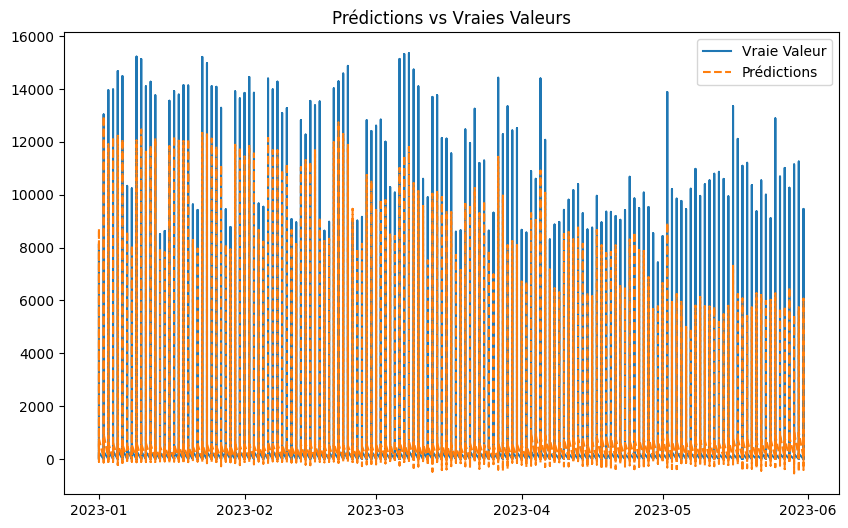

In [69]:

# Tracer les prédictions vs vraies valeurs
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Vraie Valeur')
plt.plot(y_test.index[40:], y_pred, label='Prédictions', linestyle='--')
plt.legend()
plt.title('Prédictions vs Vraies Valeurs')
plt.show()


# Prediction des valeurs avec les paramètres retenus de la recheche par grille (Xgboost)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:24:25] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


temps d execution :  37.56256914138794
RMSE: 118.73713291272375


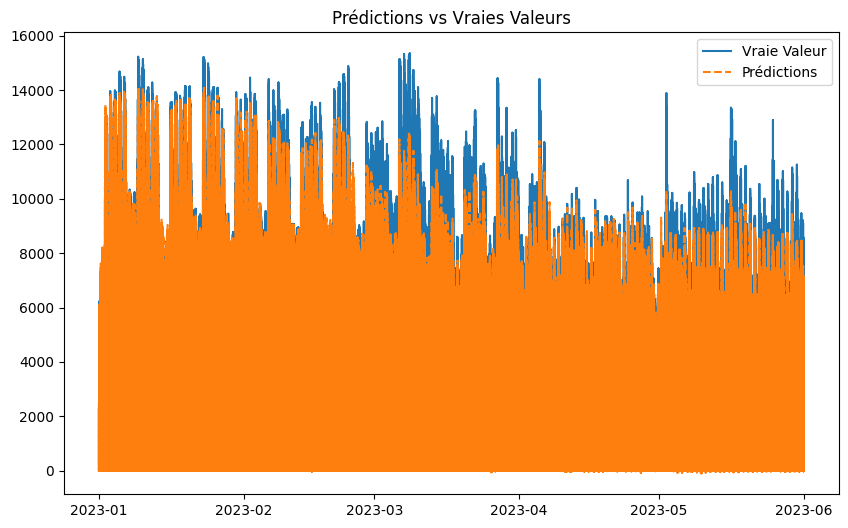

In [46]:
import time

cols = df_train_forecast2.drop(columns=[ 'latitude', 'longitude','county','row_id','origin_datetime',
                                        'date','hours_ahead','forecast_datetime','datetime',
                                        'forecast_date','origin_date','data_block_id','prediction_unit_id']).columns

# Synchroniser les indices des variables exogènes avec les composantes de la série temporelle
X_train = df_train_forecast2.loc[(df_train_forecast2.index.year>=2021)&(df_train_forecast2.index.year<=2022), cols]
X_test = df_train_forecast2.loc[(df_train_forecast2.index.year==2023), cols]
# Utiliser les composantes pour la modélisation
# Séparation des données en ensemble d'entraînement et de test
y_train = df_train_forecast2.target.loc[(df_train_forecast2.index.year>=2021)&(df_train_forecast2.index.year<=2022)]
y_test = df_train_forecast2.target.loc[(df_train_forecast2.target.index.year == 2023)]

lags = [1, 2, 3, 7, 14, 40] 

X_train_lag = create_lagged_features(X_train,'target',lags=lags)
X_train_lag.dropna(inplace=True)
X_test_lag = create_lagged_features(X_test,'target',lags=lags)
X_test_lag.dropna(inplace=True)

t1 = time.time()
# Créer et entraîner le modèle XGBoost
model = XGBRegressor(objective='reg:squarederror', subsample = 0.6, n_estimators=300, learning_rate=0.1, max_depth=6,tree_method='hist', device='cuda')
model.fit(X_train_lag, y_train[40:])
t2 = time.time()
print('temps d execution : ', (t2-t1))# Meilleurs paramètres trouvés : {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6}
# Meilleurs paramètres trouvés : {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6}
# Faire des prédictions
y_pred = model.predict(X_test_lag)

# Calculer l'erreur quadratique moyenne
rmse = np.sqrt(mean_squared_error(y_test[40:], y_pred))
print(f'RMSE: {rmse}')

plt.figure(figsize=(10, 6))
plt.plot(y_test.index[40:], y_test[40:], label='Vraie Valeur')
plt.plot(y_test.index[40:], y_pred, label='Prédictions', linestyle='--')
plt.legend()
plt.title('Prédictions vs Vraies Valeurs')
plt.show()

In [47]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [49]:
counter = 0
for (test, revealed_targets, client, historical_weather,
        forecast_weather, electricity_prices, gas_prices, sample_prediction) in iter_test:
    if counter == 0:
        display(test.head(3))
        display(revealed_targets.head(3))
        display(client.head(3))
        display(historical_weather.head(3))
        display(forecast_weather.head(3))
        display(electricity_prices.head(3))
        display(gas_prices.head(3))
        display(sample_prediction.head(3))
    sample_prediction['target'] = 0
    env.predict(sample_prediction)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


county  is_business  product_type  is_consumption  prediction_datetime  \
0       0        False             1           False  1685232000000000000   
1       0        False             1            True  1685232000000000000   
2       0        False             2           False  1685232000000000000   

    row_id  prediction_unit_id  currently_scored  
0  2005872                   0             False  
1  2005873                   0             False  
2  2005874                   1             False

county  is_business  product_type   target  is_consumption  \
0       0        False             1    2.675           False   
1       0        False             1  471.887            True   
2       0        False             2    0.000           False   

              datetime   row_id  prediction_unit_id  
0  1685059200000000000  1999536                   0  
1  1685059200000000000  1999537                   0  
2  1685059200000000000  1999538                   1

product_type  county  eic_count  installed_capacity  is_business  \
0             1       0        507         4960.214844        False   
1             2       0         11           34.000000        False   
2             3       0       1516        15977.559570        False   

                  date  
0  1685059200000000000  
1  1685059200000000000  
2  1685059200000000000

datetime  temperature  dewpoint  rain  snowfall  \
0  1685098800000000000         13.5       9.0   0.0       0.0   
1  1685098800000000000         13.4       8.9   0.2       0.0   
2  1685098800000000000         16.4       7.8   0.2       0.0   

   surface_pressure  cloudcover_total  cloudcover_low  cloudcover_mid  \
0       1018.500000                30            31.0             3.0   
1       1013.200012                47            31.0            32.0   
2       1017.700012                60            21.0            69.0   

   cloudcover_high  windspeed_10m  winddirection_10m  shortwave_radiation  \
0              0.0       6.305555              272.0                592.0   
1              0.0       6.111111              268.0                612.0   
2              0.0       6.138889              263.0                655.0   

   direct_solar_radiation  diffuse_radiation   latitude  longitude  
0                   420.0              172.0  57.599998  21.700001  
1                   446.0              166.0  57.599998  22.200001  
2                   512.0              143.0  57.599998  22.700001

latitude  longitude      origin_datetime  hours_ahead  temperature  \
0  57.599998  21.700001  1685152800000000000            1     9.859156   
1  57.599998  22.200001  1685152800000000000            1     5.916284   
2  57.599998  22.700001  1685152800000000000            1     9.111963   

   dewpoint  cloudcover_high  cloudcover_low  cloudcover_mid  \
0  5.508813              0.0             0.0        0.026901   
1  4.613428              0.0             0.0        0.000000   
2  6.878442              0.0             0.0        0.000000   

   cloudcover_total  10_metre_u_wind_component  10_metre_v_wind_component  \
0          0.026901                   3.616620                  -1.281012   
1          0.000000                   2.164227                  -0.245367   
2          0.000000                   3.809247                  -1.583502   

     forecast_datetime  direct_solar_radiation  \
0  1685156400000000000                     0.0   
1  1685156400000000000                     0.0   
2  1685156400000000000                     0.0   

   surface_solar_radiation_downwards  snowfall  total_precipitation  
0                                0.0       0.0                  0.0  
1                                0.0       0.0                  0.0  
2                                0.0       0.0                  0.0

forecast_date  euros_per_mwh          origin_date
0  1685145600000000000          87.54  1685059200000000000
1  1685149200000000000          82.69  1685062800000000000
2  1685152800000000000          82.70  1685066400000000000

forecast_date  lowest_price_per_mwh  highest_price_per_mwh  \
0  1685145600000000000             28.299999              34.099998   

           origin_date  
0  1685059200000000000

row_id  target
0  2005872     0.0
1  2005873     0.0
2  2005874     0.0

In [50]:
sample_prediction

row_id  target
0     2015232       0
1     2015233       0
2     2015234       0
3     2015235       0
4     2015236       0
...       ...     ...
3115  2018347       0
3116  2018348       0
3117  2018349       0
3118  2018350       0
3119  2018351       0

[3120 rows x 2 columns]

In [51]:
mask = dataset_test.row_id.isin(sample_prediction.row_id)
dataset_test.loc[dataset_test.row_id.loc[mask].index]

county  is_business  product_type  is_consumption  prediction_datetime  \
9360        0            0             1               0  2023-05-31 00:00:00   
9361        0            0             1               1  2023-05-31 00:00:00   
9362        0            0             2               0  2023-05-31 00:00:00   
9363        0            0             2               1  2023-05-31 00:00:00   
9364        0            0             3               0  2023-05-31 00:00:00   
...       ...          ...           ...             ...                  ...   
12475      15            1             0               1  2023-05-31 23:00:00   
12476      15            1             1               0  2023-05-31 23:00:00   
12477      15            1             1               1  2023-05-31 23:00:00   
12478      15            1             3               0  2023-05-31 23:00:00   
12479      15            1             3               1  2023-05-31 23:00:00   

       data_block_id   row_id  prediction_unit_id  currently_scored  
9360             637  2015232                   0             False  
9361             637  2015233                   0             False  
9362             637  2015234                   1             False  
9363             637  2015235                   1             False  
9364             637  2015236                   2             False  
...              ...      ...                 ...               ...  
12475            637  2018347                  64             False  
12476            637  2018348                  59             False  
12477            637  2018349                  59             False  
12478            637  2018350                  60             False  
12479            637  2018351                  60             False  

[3120 rows x 9 columns]

In [52]:
df_pred = df_train_forecast2.loc[(df_train_forecast2.index.year==2023)].iloc[40:,:]

df_pred['target_pred'] = y_pred

mask = df_pred.row_id.isin(dataset_sample_submission.row_id)

df_pred = df_pred.loc[mask]

In [53]:
df_pred

latitude  longitude     origin_datetime  hours_ahead  \
datetime                                                                    
2023-05-28 00:00:00      59.1       26.7 2023-05-17 02:00:00           11   
2023-05-28 00:00:00      59.1       27.2 2023-05-17 02:00:00           11   
2023-05-28 00:00:00      59.1       27.7 2023-05-17 02:00:00           11   
2023-05-28 00:00:00      59.1       28.2 2023-05-17 02:00:00           11   
2023-05-28 00:00:00      59.4       21.7 2023-05-17 02:00:00           11   
...                       ...        ...                 ...          ...   
2023-05-31 23:00:00      57.6       27.2 2023-05-19 02:00:00           27   
2023-05-31 23:00:00      57.6       27.7 2023-05-19 02:00:00           27   
2023-05-31 23:00:00      57.6       28.2 2023-05-19 02:00:00           27   
2023-05-31 23:00:00      57.9       21.7 2023-05-19 02:00:00           27   
2023-05-31 23:00:00      57.9       22.2 2023-05-19 02:00:00           27   

                     temperature  dewpoint  cloudcover_high  cloudcover_low  \
datetime                                                                      
2023-05-28 00:00:00    17.115137  6.477930         0.708496        0.478880   
2023-05-28 00:00:00    16.948877  9.078760         0.136932        0.372755   
2023-05-28 00:00:00    16.704980  9.628809         0.261322        0.168104   
2023-05-28 00:00:00    16.835352  8.997949         0.077972        0.170591   
2023-05-28 00:00:00     7.983301  6.546045         0.000000        0.102125   
...                          ...       ...              ...             ...   
2023-05-31 23:00:00     6.970850  4.764063         0.000702        0.000000   
2023-05-31 23:00:00     7.181787  4.992334         0.012115        0.000000   
2023-05-31 23:00:00     6.324609  3.546045         0.053864        0.000000   
2023-05-31 23:00:00     9.581201  6.506738         0.754181        0.000000   
2023-05-31 23:00:00     9.692285  6.616846         0.054352        0.000000   

                     cloudcover_mid  cloudcover_total  ...  day  weekday  \
datetime                                               ...                 
2023-05-28 00:00:00        0.440338          0.898105  ...   28        6   
2023-05-28 00:00:00        0.453796          0.657077  ...   28        6   
2023-05-28 00:00:00        0.536987          0.682971  ...   28        6   
2023-05-28 00:00:00        0.709167          0.760531  ...   28        6   
2023-05-28 00:00:00        0.001923          0.102496  ...   28        6   
...                             ...               ...  ...  ...      ...   
2023-05-31 23:00:00        0.000000          0.000702  ...   31        2   
2023-05-31 23:00:00        0.000000          0.012115  ...   31        2   
2023-05-31 23:00:00        0.000000          0.053864  ...   31        2   
2023-05-31 23:00:00        0.000000          0.754181  ...   31        2   
2023-05-31 23:00:00        0.000000          0.054352  ...   31        2   

                     month  year  dayofyear  sin_dayofyear  cos_dayofyear  \
datetime                                                                    
2023-05-28 00:00:00      5  2023        148       0.565345      -0.824855   
2023-05-28 00:00:00      5  2023        148       0.565345      -0.824855   
2023-05-28 00:00:00      5  2023        148       0.565345      -0.824855   
2023-05-28 00:00:00      5  2023        148       0.565345      -0.824855   
2023-05-28 00:00:00      5  2023        148       0.565345      -0.824855   
...                    ...   ...        ...            ...            ...   
2023-05-31 23:00:00      5  2023        151       0.522133      -0.852864   
2023-05-31 23:00:00      5  2023        151       0.522133      -0.852864   
2023-05-31 23:00:00      5  2023        151       0.522133      -0.852864   
2023-05-31 23:00:00      5  2023        151       0.522133      -0.852864   
2023-05-31 23:00:00      5  2023        151       0.522133      -0.852864   



In [54]:
df_pred.target_pred.values

array([3.3090854e+00, 6.2574628e+02, 2.4920184e-02, ..., 2.8684139e+01,
       2.4920184e-02, 1.9617920e+02], dtype=float32)

In [55]:
dataset_sample_submission.loc[:,'target'] = df_pred.target_pred.values.copy()
dataset_sample_submission

/tmp/ipykernel_33/2306901065.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3.3090854e+00 6.2574628e+02 2.4920184e-02 ... 2.8684139e+01 2.4920184e-02
 1.9617920e+02]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset_sample_submission.loc[:,'target'] = df_pred.target_pred.values.copy()


row_id  data_block_id      target
0      2005872            634    3.309085
1      2005873            634  625.746277
2      2005874            634    0.024920
3      2005875            634    4.741823
4      2005876            634  143.043564
...        ...            ...         ...
12475  2018347            637  196.167877
12476  2018348            637    0.024920
12477  2018349            637   28.684139
12478  2018350            637    0.024920
12479  2018351            637  196.179199

[12480 rows x 3 columns]

# 3.3 Prédiction de la variable target avec le réseau de neurone LSTM

In [63]:
cols

Index(['temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component',
       '10_metre_v_wind_component', 'direct_solar_radiation',
       'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation',
       'is_business', 'product_type', 'target', 'is_consumption',
       'lowest_price_per_mwh', 'highest_price_per_mwh', 'eic_count',
       'installed_capacity', 'hour', 'day', 'weekday', 'month', 'year',
       'dayofyear', 'sin_dayofyear', 'cos_dayofyear', 'sin_hour', 'cos_hour'],
      dtype='object')

In [56]:

# Synchroniser les indices des variables exogènes avec les composantes de la série temporelle
X_train = df_train_forecast2.loc[(df_train_forecast2.index.year>=2021)&(df_train_forecast2.index.year<=2022), cols]
X_test = df_train_forecast2.loc[(df_train_forecast2.index.year==2023), cols]


In [57]:
# Exemple de création de variables retardées
def create_lagged_features(df, target,lags):
    for lag in lags:
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)
    return df

lags = [1, 2, 3, 7, 14, 20,30,40] 
X_train_lag = create_lagged_features(X_train,'target',lags=lags)
X_train_lag.dropna(inplace=True)
X_test_lag = create_lagged_features(X_test,'target',lags=lags)
X_test_lag.dropna(inplace=True)

In [58]:
X_train_lag.drop(columns=['target'],inplace=True)
X_test_lag.drop(columns=['target'],inplace=True)

In [59]:

X_train_lag.select_dtypes(include=np.number)


temperature   dewpoint  cloudcover_high  cloudcover_low  \
datetime                                                                       
2021-09-03 00:00:00    13.438379   5.971277         0.000000        0.378929   
2021-09-03 00:00:00    13.111108   6.287561         0.000000        0.271004   
2021-09-03 00:00:00    11.285547   6.973047         0.000000        0.097237   
2021-09-03 00:00:00    10.332422   7.183130         0.000000        0.004967   
2021-09-03 00:00:00     9.718530   6.949121         0.000000        0.000008   
...                          ...        ...              ...             ...   
2022-12-31 23:00:00    -1.900488  -3.691260         0.786869        0.804810   
2022-12-31 23:00:00    -2.497656  -4.331885         0.681065        0.115784   
2022-12-31 23:00:00    -5.169043  -7.009131         0.163609        0.199646   
2022-12-31 23:00:00    -6.503271  -8.876562         0.513767        0.091522   
2022-12-31 23:00:00    -7.824072 -10.522559         0.865010        0.013916   

                     cloudcover_mid  cloudcover_total  \
datetime                                                
2021-09-03 00:00:00        0.351776          0.495804   
2021-09-03 00:00:00        0.228546          0.380661   
2021-09-03 00:00:00        0.095917          0.149811   
2021-09-03 00:00:00        0.007645          0.010651   
2021-09-03 00:00:00        0.001114          0.001114   
...                             ...               ...   
2022-12-31 23:00:00        0.999999          1.000002   
2022-12-31 23:00:00        0.999999          1.000002   
2022-12-31 23:00:00        0.999999          1.000002   
2022-12-31 23:00:00        0.999999          1.000002   
2022-12-31 23:00:00        0.999938          0.999994   

                     10_metre_u_wind_component  10_metre_v_wind_component  \
datetime                                                                    
2021-09-03 00:00:00                   3.941953                  -7.750890   
2021-09-03 00:00:00                   3.298765                  -7.350743   
2021-09-03 00:00:00                   1.860655                  -3.171788   
2021-09-03 00:00:00                   2.339536                  -2.933751   
2021-09-03 00:00:00                   2.644468                  -2.315343   
...                                        ...                        ...   
2022-12-31 23:00:00                   0.047939                   5.122638   
2022-12-31 23:00:00                  -0.463779                   3.290362   
2022-12-31 23:00:00                  -1.203281                   3.235187   
2022-12-31 23:00:00                  -0.937168                   3.131915   
2022-12-31 23:00:00                   0.098721                   2.925616   

                     direct_solar_radiation  \
datetime                                      
2021-09-03 00:00:00              209.401615   
2021-09-03 00:00:00              256.857170   
2021-09-03 00:00:00              306.821615   
2021-09-03 00:00:00              352.961615   
2021-09-03 00:00:00              362.521615   
...                                     ...   
2022-12-31 23:00:00                0.000000   
2022-12-31 23:00:00                0.000000   
2022-12-31 23:00:00                0.000000   
2022-12-31 23:00:00                0.000000   
2022-12-31 23:00:00                0.000000   

                     surface_solar_radiation_downwards  ...  sin_hour  \
datetime                                                ...             
2021-09-03 00:00:00                          59.425209  ...  0.000000   
2021-09-03 00:00:00                          68.864098  ...  0.000000   
2021-09-03 00:00:00                          78.557153  ...  0.000000   
2021-09-03 00:00:00                          87.219653  ...  0.000000   
2021-09-03 00:00:00                          91.119098  ...  0.000000   
...                                                ...  ...       ...   
2022-12-31 23:00:00                     

In [60]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from keras.callbacks import EarlyStopping


seq_size = length = 10
batch_size = 32
train_generator = TimeseriesGenerator(X_train_lag[:500000], y_train[40:500040],stride = 1, length = 10, batch_size=batch_size)


print('nombre d échantillon :',len(train_generator))

2024-07-11 18:36:00.493433: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 18:36:00.493591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 18:36:00.647203: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


nombre d échantillon : 15625


In [61]:
x, y = train_generator[0]
x[0][0]

/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


array([ 1.34383789e+01,  5.97127686e+00,  0.00000000e+00,  3.78929138e-01,
        3.51776123e-01,  4.95803833e-01,  3.94195342e+00, -7.75088978e+00,
        2.09401615e+02,  5.94252090e+01,  0.00000000e+00,  1.47819519e-05,
        0.00000000e+00,  3.00000000e+00,  0.00000000e+00,  4.56200000e+01,
        4.62900000e+01,  8.90000000e+01,  1.10530000e+03,  0.00000000e+00,
        3.00000000e+00,  4.00000000e+00,  9.00000000e+00,  2.02100000e+03,
        2.46000000e+02, -8.82678798e-01, -4.69976743e-01,  0.00000000e+00,
        1.00000000e+00,  2.06740000e+01,  1.99800000e+00,  2.15945000e+02,
        2.55490000e+01,  0.00000000e+00,  0.00000000e+00,  4.49000000e-01,
        7.93000000e-01])

In [62]:
batch_size = 32

validate_generator = TimeseriesGenerator(X_train_lag[500000:700000], y_train[500040:700040],stride = 1, length = 10, batch_size=batch_size)
print('nombre d échantillon :',len(validate_generator))
x, y = validate_generator[989]


X_train.shape

nombre d échantillon : 6250


(1529706, 37)

In [78]:
import tensorflow as tf

# Vérifier la disponibilité du GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [64]:
num_feature = 37
model = Sequential()
model.add(LSTM(50, activation="relu", return_sequences=True, input_shape=(length,num_feature)))
model.add(LSTM(50, activation="relu"))
model.add(Dense(1))
model.compile( optimizer='adam', loss='mean_squared_error')
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        17,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,851 (147.86 KB)

 Trainable params: 37,851 (147.86 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# Définir le callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:

history = model.fit(train_generator, verbose=2, epochs=4, validation_data=validate_generator,callbacks=[early_stopping])
train_pred = model.predict(train_generator)
valid_pred = model.predict(validate_generator)

Epoch 1/4


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15625/15625 - 305s - 20ms/step - loss: 228831.0938 - val_loss: 129680.2500
Epoch 2/4
15625/15625 - 301s - 19ms/step - loss: 118701.2500 - val_loss: 725765.8750
Epoch 3/4


In [83]:
valid_pred = model.predict(validate_generator)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 70s 11ms/step


In [85]:
valid_pred.shape, y_train[100040:200040].shape

((199990, 1), (100000,))

In [86]:
mse = np.sqrt(mean_squared_error(valid_pred, y_train[500050:700040]))
print(f'MSE: {mse}')

MSE: 467.60934398042474


In [87]:
df_pred = pd.DataFrame(valid_pred, index=y_train.index[500050:700040], columns=["y_pred"])
df_pred

y_pred
datetime              
2022-02-14   82.136452
2022-02-14  156.735336
2022-02-14   80.311325
2022-02-14   95.463051
2022-02-14  156.825027
...                ...
2022-04-18   83.208115
2022-04-18   14.921109
2022-04-18   10.492421
2022-04-18  222.006546
2022-04-18  555.374451

[199990 rows x 1 columns]

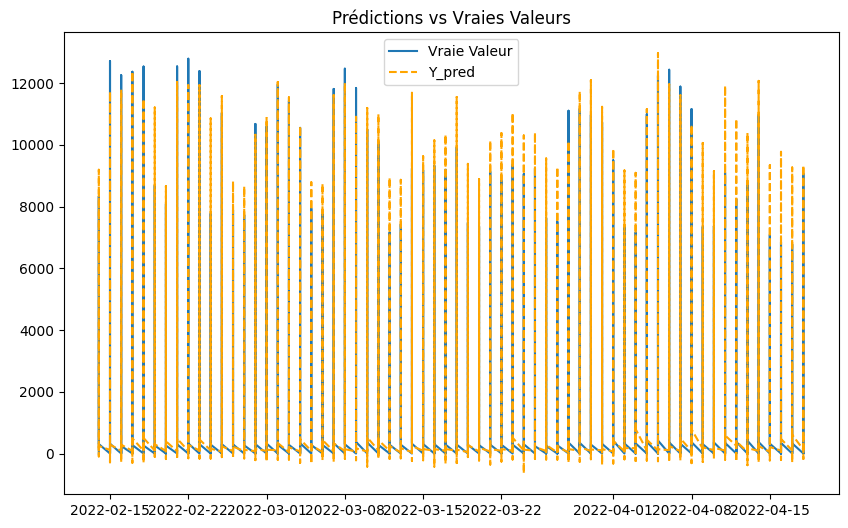

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(y_train[500040:700030].index, y_train[500040:700030], label='Vraie Valeur')
plt.plot(df_pred.index, df_pred.values, label='Y_pred', linestyle='--', color='orange')
plt.legend()
plt.title('Prédictions vs Vraies Valeurs')
plt.show()

In [ ]:
pd.Series(test_pred.reshape(1,99127))

In [90]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

# Vérifier la disponibilité du GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Normaliser les données
scaler = MinMaxScaler()
X_train_lag = scaler.fit_transform(X_train_lag)

# Définir les générateurs de séquences
seq_size = length = 10
batch_size = 32  # Utiliser un batch size plus grand

train_generator = TimeseriesGenerator(X_train_lag[:500000], y_train[40:500040], stride=1, length=seq_size, batch_size=batch_size)
validate_generator = TimeseriesGenerator(X_train_lag[500000:700000], y_train[500040:700040], stride=1, length=seq_size, batch_size=batch_size)

print('Nombre d\'échantillons d\'entraînement :', len(train_generator))
print('Nombre d\'échantillons de validation :', len(validate_generator))

# Définir le modèle LSTM avec Dropout


# Définir le callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


num_features = X_train_lag.shape[1]

model = Sequential()
model.add(LSTM(50, activation="relu", return_sequences=True, input_shape=(length, num_features)))
model.add(Dropout(0.2))  # Ajouter un dropout après la première couche LSTM
model.add(LSTM(50, activation="relu"))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

# Entraîner le modèle
history = model.fit(train_generator, verbose=2, epochs=3, validation_data=validate_generator, callbacks=[early_stopping])



Num GPUs Available:  2
Nombre d'échantillons d'entraînement : 15625
Nombre d'échantillons de validation : 6250


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 50)         │        17,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,451 (146.29 KB)

 Trainable params: 37,451 (146.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15625/15625 - 69s - 4ms/step - loss: 313638.6562 - val_loss: 238677.3594
Epoch 2/3
15625/15625 - 60s - 4ms/step - loss: 142158.1406 - val_loss: 247446.2500
Epoch 3/3
15625/15625 - 60s - 4ms/step - loss: 77395.3906 - val_loss: 146528.4219


In [95]:
# Prédictions
train_pred = model.predict(train_generator)
test_pred = model.predict(validate_generator)




   50/15625 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step 

/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


15625/15625 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


In [96]:
test_pred.shape, y_train.index[100040:100040+len(test_pred)].shape

((199990, 1), (199990,))

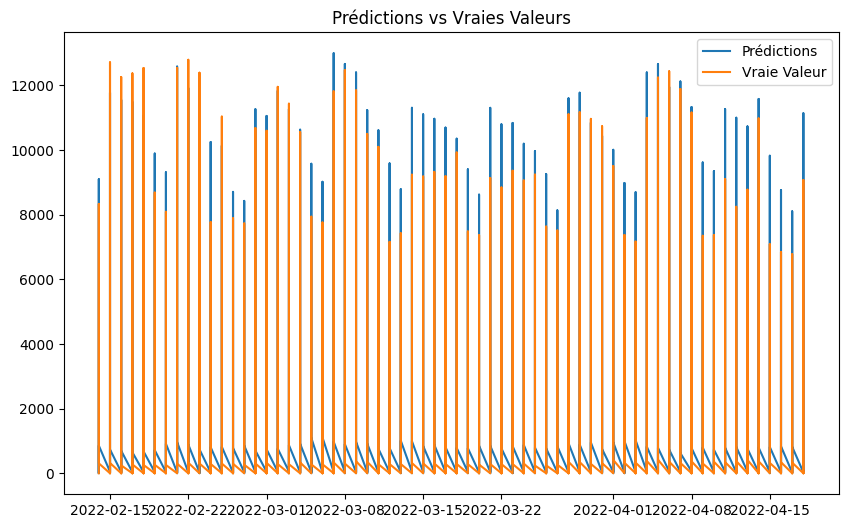

In [97]:
df_pred = pd.DataFrame(test_pred, index=y_train.index[500040:500040+len(test_pred)], columns=["y_pred"])

# Afficher les résultats
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df_pred, label='Prédictions')
plt.plot(y_train[500040:500040+len(test_pred)], label='Vraie Valeur')
plt.legend()
plt.title('Prédictions vs Vraies Valeurs')
plt.show()

In [99]:
mse = np.sqrt(mean_squared_error(test_pred, y_train[100040:100040+len(test_pred)]))
print(f'MSE: {mse}')

MSE: 1219.3117685012755


# Data information

### train.csv

- county - An ID code for the county.
- is_business - Boolean for whether or not the prosumer is a business.
- product_type - ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.
- target - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.
- is_consumption - Boolean for whether or not this row's target is consumption or production.
- datetime - The Estonian time in EET (UTC+2) / EEST (UTC+3). It describes the start of the 1-hour period on which target is given.
- data_block_id - All rows sharing the same data_block_id will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast - - weather data_block_id for predictins made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.
- row_id - A unique identifier for the row.
- prediction_unit_id - A unique identifier for the county, is_business, and product_type combination. New prediction units can appear or disappear in the test set.
- gas_prices.csv

### gas_prices.csv

- origin_date - The date when the day-ahead prices became available.
- forecast_date - The date when the forecast prices should be relevant.
- [lowest/highest]_price_per_mwh - The lowest/highest price of natural gas that on the day ahead market that trading day, in Euros per megawatt hour equivalent.
- data_block_id
- client.csv

### client.csv

- product_type
- county - An ID code for the county. See county_id_to_name_map.json for the mapping of ID codes to county names.
- eic_count - The aggregated number of consumption points (EICs - European Identifier Code).
- installed_capacity - Installed photovoltaic solar panel capacity in kilowatts.
- is_business - Boolean for whether or not the prosumer is a business.
- date
- data_block_id
- electricity_prices.csv

### electricity_prices.csv

- origin_date
- forecast_date - Represents the start of the 1-hour period when the price is valid
- euros_per_mwh - The price of electricity on the day ahead markets in euros per megawatt hour.
- data_block_id
- forecast_weather.csv Weather forecasts that would have been available at prediction time. Sourced from the European Centre for Medium-Range Weather Forecasts.

### forecast_weather.csv

- [latitude/longitude] - The coordinates of the weather forecast.
- origin_datetime - The timestamp of when the forecast was generated.
- hours_ahead - The number of hours between the forecast generation and the forecast weather. Each forecast covers 48 hours in total.
- temperature - The air temperature at 2 meters above ground in degrees Celsius. Estimated for the end of the 1-hour period.
- dewpoint - The dew point temperature at 2 meters above ground in degrees Celsius. Estimated for the end of the 1-hour period.
- cloudcover_[low/mid/high/total] - The percentage of the sky covered by clouds in the following altitude bands: 0-2 km, 2-6, 6+, and total. Estimated for the end of the 1-hour period.
- 10_metre_[u/v]_wind_component - The [eastward/northward] component of wind speed measured 10 meters above surface in meters per second. Estimated for the end of the 1-hour period.
- data_block_id
- forecast_datetime - The timestamp of the predicted weather. Generated from origin_datetime plus hours_ahead. This represents the start of the 1-hour period for which weather data are forecasted.
- direct_solar_radiation - The direct solar radiation reaching the surface on a plane perpendicular to the direction of the Sun accumulated during the hour, in watt-hours per square meter.
- surface_solar_radiation_downwards - The solar radiation, both direct and diffuse, that reaches a horizontal plane at the surface of the Earth, accumulated during the hour, in watt-hours per square meter.
- snowfall - Snowfall over hour in units of meters of water equivalent.
- total_precipitation - The accumulated liquid, comprising rain and snow that falls on Earth's surface over the described hour, in units of meters.
- historical_weather.csv Historic weather data.

### historical_weather.csv

- datetime - This represents the start of the 1-hour period for which weather data are measured.
- temperature - Measured at the end of the 1-hour period.
- dewpoint - Measured at the end of the 1-hour period.
- rain - Different from the forecast conventions. The rain from large scale weather systems of the hour in millimeters.
- snowfall - Different from the forecast conventions. Snowfall over the hour in centimeters.
- surface_pressure - The air pressure at surface in hectopascals.
- cloudcover_[low/mid/high/total] - Different from the forecast conventions. Cloud cover at 0-3 km, 3-8, 8+, and total.
- windspeed_10m - Different from the forecast conventions. The wind speed at 10 meters above ground in meters per second.
- winddirection_10m - Different from the forecast conventions. The wind direction at 10 meters above ground in degrees.
- shortwave_radiation - Different from the forecast conventions. The global horizontal irradiation in watt-hours per square meter.
- direct_solar_radiation
- diffuse_radiation - Different from the forecast conventions. The diffuse solar irradiation in watt-hours per square meter.
- [latitude/longitude] - The coordinates of the weather station.
- data_block_id